# MSc Artificial Intelligence Thesis Project

This notebook contains the **final implementation** of the Hybrid ViT-CNN model for stroke classification.  
It includes the full pipeline of **preprocessing, model construction, training, and evaluation**.

---

## Notebook Overview

1. **Preprocessing Pipeline** – Cleaning, cropping, resizing, and enhancing brain CT images.  
2. **Dataset Preparation** – Splitting into train/validation/test sets.  
3. **Model Construction** – Hybrid Vision Transformer (ViT) with CNN backbone.  
4. **Training & Optimization** – Loss, learning rate scheduling, and optimizer setup.  
5. **Evaluation & Results** – Accuracy, F1 score, confusion matrix, and GradCAM visualization.  
6. **Conclusion** – Summary of findings.



In [4]:

# Install required packages
!pip install torch torchvision transformers torchcam scikit-learn pillow numpy opencv-python -q

# Brain Stroke Classification: Ischemic vs Hemorrhagic
# MSc Artificial Intelligence - Thesis Project
# Author: [Your Name]
# Date: [Current Date]

"""
This notebook implements a hybrid CNN-Vision Transformer model for classifying brain stroke types
from CT scan images. The model distinguishes between ischemic and hemorrhagic strokes using
advanced deep learning techniques including:

- Image preprocessing pipeline with CLAHE enhancement
- Hybrid architecture combining ResNet18 and ViT-Base
- K-fold cross-validation for robust evaluation
- Data augmentation and regularization techniques
- LIME explainability analysis
- Comprehensive performance evaluation

Dataset: Brain stroke CT scans (ischemic vs hemorrhagic)
Architecture: Hybrid CNN-ViT model
Validation: 3-fold stratified cross-validation
"""


# Import core libraries
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
import shutil
import random

# List dataset files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Cell 1: Imports**

In [5]:
# ================================================================================================
# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS
# ================================================================================================
print("=" * 80)
print("BRAIN STROKE CLASSIFICATION - MSC AI THESIS")
print("=" * 80)
print("Setting up environment and importing required libraries...")

# Advanced training components
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

# Additional imports for model architecture and evaluation
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTConfig, ViTForImageClassification
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import torchvision.models as models
from transformers import ViTModel
from datetime import datetime

BRAIN STROKE CLASSIFICATION - MSC AI THESIS
Setting up environment and importing required libraries...


**cell 2: Preprocessing Functions (Including Visualization)**

## Preprocessing Pipeline

This section defines the preprocessing functions used to prepare CT brain images for training.  
Steps include:
- **Cropping** to remove unnecessary borders.  
- **Resizing** to 224×224 for compatibility with ViT.  
- **Cleaning** using thresholding and connected components to isolate the skull region.  
- **Contrast Enhancement** with CLAHE (Contrast Limited Adaptive Histogram Equalization).  
- **Normalization** to scale pixel intensities between 0–255.  
- **Dataset Splitting** into train/validation/test sets.

In [6]:
# ================================================================================================
# SECTION 2: IMAGE PREPROCESSING PIPELINE
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 2: IMAGE PREPROCESSING PIPELINE")
print("=" * 80)

def cleanUp(img): 
    """
    Remove background noise and isolate brain tissue from CT scan images.
    
    Process:
    1. Convert to grayscale and apply binary thresholding
    2. Remove background pixels (set to black)
    3. Find connected components to identify brain tissue
    4. Keep only the largest connected component (main brain region)
    
    Args:
        img (numpy.ndarray): Input BGR image
        
    Returns:
        numpy.ndarray: Cleaned image with background removed
    """
    # Convert to grayscale for thresholding
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Binary threshold to separate foreground from background
    _, thresh = cv.threshold(gray_img, 200, 255, cv.THRESH_BINARY)

    # Create clean image copy and remove background
    clean_img = img.copy()
    clean_img[(thresh < 254) == False] = (0, 0, 0)

    # Find connected components to identify brain regions
    gray_img = cv.cvtColor(clean_img, cv.COLOR_BGR2GRAY)
    _, markers = cv.connectedComponents(gray_img)

    # Calculate area of each connected component
    marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0]

    # Keep only the largest connected component (main brain tissue)
    if len(marker_area) != 0:
        largest_component = np.argmax(marker_area) + 1
        skull_mask = markers == largest_component
        clean_img[skull_mask == False] = (0, 0, 0)
    
    return clean_img

def imageCropping(img):
    """
    Crop CT scan from 512x512 to 400x400 to remove border artifacts.
    This removes the outer 56 pixels on each side, focusing on the central brain region.
    
    Args:
        img (numpy.ndarray): Input image of size 512x512
        
    Returns:
        numpy.ndarray: Cropped image of size 400x400
    """
    return img[56:456, 56:456]

def imageResizing(img):
    """
    Resize image to 224x224 pixels for Vision Transformer compatibility.
    ViT models require fixed input size of 224x224.
    
    Args:
        img (numpy.ndarray): Input image
        
    Returns:
        numpy.ndarray: Resized image (224x224)
    """
    return cv.resize(img, (224, 224))

def preprocess_image(image_path, output_path):
    """
    Complete preprocessing pipeline for a single CT scan image.
    
    Pipeline stages:
    1. Load image
    2. Crop to remove borders
    3. Resize to standard dimensions
    4. Clean up background noise
    5. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    6. Normalize intensity values
    
    Args:
        image_path (str): Path to input image
        output_path (str): Path to save processed image
        
    Returns:
        bool: True if successful, False otherwise
    """

    # Load the CT scan image
    img = cv.imread(image_path) 
    if img is None:
        return False

    # Apply preprocessing steps
    cropped_img = imageCropping(img)
    resized_img = imageResizing(cropped_img)
    clean_img = cleanUp(resized_img)

    # Apply CLAHE for contrast enhancement
    # CLAHE prevents over-amplification of noise while enhancing local contrast
    lab = cv.cvtColor(clean_img, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv.merge((l_enhanced, a, b))
    enhanced_img = cv.cvtColor(lab_enhanced, cv.COLOR_LAB2BGR)

    # Intensity normalization to [0, 255] range
    enhanced_img = enhanced_img.astype(np.float32)
    img_min, img_max = enhanced_img.min(), enhanced_img.max()
    if img_max > img_min:
        normalized_img = ((enhanced_img - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    else:
        normalized_img = enhanced_img.astype(np.uint8)

    # Save the processed image
    cv.imwrite(output_path, normalized_img)
    return True

def preprocess_image_with_stages(image_path):
    """
    Process image and return all intermediate stages for visualization.
    This function is used to demonstrate the preprocessing pipeline effects.
    
    Args:
        image_path (str): Path to input image
        
    Returns:
        dict: Dictionary containing all preprocessing stages
    """
    
    img = cv.imread(image_path)
    if img is None:
        return None

    # Apply each preprocessing step and store results
    cropped_img = img[56:456, 56:456]
    resized_img = cv.resize(cropped_img, (224, 224))
    clean_img = cleanUp(resized_img)

    # CLAHE enhancement
    lab = cv.cvtColor(clean_img, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv.merge((l_enhanced, a, b))
    enhanced_img = cv.cvtColor(lab_enhanced, cv.COLOR_LAB2BGR)

    # Final normalization
    enhanced_img = enhanced_img.astype(np.float32)
    img_min, img_max = enhanced_img.min(), enhanced_img.max()
    if img_max > img_min:
        normalized_img = ((enhanced_img - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    else:
        normalized_img = enhanced_img.astype(np.uint8)

    # Return all stages with RGB conversion for matplotlib
    return {
        'Original': cv.cvtColor(img, cv.COLOR_BGR2RGB),
        'Cropped': cv.cvtColor(cropped_img, cv.COLOR_BGR2RGB),
        'Resized': cv.cvtColor(resized_img, cv.COLOR_BGR2RGB),
        'Cleaned': cv.cvtColor(clean_img, cv.COLOR_BGR2RGB),
        'CLAHE Enhanced': cv.cvtColor(enhanced_img, cv.COLOR_BGR2RGB),
        'Normalized': cv.cvtColor(normalized_img, cv.COLOR_BGR2RGB)
    }

def plot_preprocessing_stages(image_path, save_path='figures/preprocessing_stages.png'):
    """
    Visualize all preprocessing stages in a single figure.
    This helps understand the effect of each preprocessing step.
    
    Args:
        image_path (str): Path to input image
        save_path (str): Path to save the visualization
    """
    stages = preprocess_image_with_stages(image_path)
    if stages is None:
        print("Failed to load image.")
        return
        
    # Create subplot for each preprocessing stage
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (title, img) in enumerate(stages.items()):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def preprocess_and_split(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1):
    """
    Preprocess all images and split into train/validation/test sets.
    
    This function:
    1. Applies preprocessing pipeline to all images
    2. Randomly splits data into train/validation/test sets
    3. Maintains class balance across splits
    4. Saves processed images to appropriate directories
    
    Args:
        input_dir (str): Directory containing raw images
        output_dir (str): Directory to save processed images
        train_ratio (float): Proportion for training set (0.8 = 80%)
        val_ratio (float): Proportion for validation set (0.1 = 10%)
    """

    print(f"Starting preprocessing and data splitting...")
    print(f"Train ratio: {train_ratio}, Validation ratio: {val_ratio}, Test ratio: {1-train_ratio-val_ratio}")

    # Clean up existing directories
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    if os.path.exists('/kaggle/working/dataset_split'):
        shutil.rmtree('/kaggle/working/dataset_split')

    # Process each class separately to maintain balance
    for label in ['ischemic', 'hemorrhagic']:
        input_path = os.path.join(input_dir, label)
        processed_path = os.path.join(output_dir, label)
        os.makedirs(processed_path, exist_ok=True)

        # Preprocess all images in this class
        processed_images = {}
        for img_name in os.listdir(input_path):
            if img_name.endswith('.jpg'):
                output_name = os.path.join(processed_path, img_name.replace('.jpg', '_preprocessed.jpg'))
                success = preprocess_image(os.path.join(input_path, img_name), output_name)
                if success:
                    processed_images[img_name] = output_name

        # Randomly split processed images
        images = list(processed_images.keys())
        random.shuffle(images)

        # Calculate split indices
        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)
        
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Create split directories
        print(f"  - Train: {len(train_images)} images")
        print(f"  - Validation: {len(val_images)} images") 
        print(f"  - Test: {len(test_images)} images")
        
        os.makedirs(f'/kaggle/working/dataset_split/train/{label}', exist_ok=True)
        os.makedirs(f'/kaggle/working/dataset_split/val/{label}', exist_ok=True)
        os.makedirs(f'/kaggle/working/dataset_split/test/{label}', exist_ok=True)

        # Copy images to appropriate split directories
        for img in train_images:
            shutil.copy(processed_images[img], f'/kaggle/working/dataset_split/train/{label}/{img.replace(".jpg", "_preprocessed.jpg")}')
        for img in val_images:
            shutil.copy(processed_images[img], f'/kaggle/working/dataset_split/val/{label}/{img.replace(".jpg", "_preprocessed.jpg")}')
        for img in test_images:
            shutil.copy(processed_images[img], f'/kaggle/working/dataset_split/test/{label}/{img.replace(".jpg", "_preprocessed.jpg")}')

print("Preprocessing functions defined successfully")


SECTION 2: IMAGE PREPROCESSING PIPELINE
Preprocessing functions defined successfully


**Cell 3: Execute Preprocessing and Generate Plots**

In [7]:

# ================================================================================================
# SECTION 3: DATA PREPROCESSING AND VISUALIZATION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 3: DATA PREPROCESSING AND VISUALIZATION")
print("=" * 80)

# Set random seeds for reproducibility
print("Setting random seeds for reproducibility...")
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

# Execute preprocessing and splitting
print("Executing preprocessing and data splitting...")
preprocess_and_split('/kaggle/input/brain-stroke/dataset', '/kaggle/working/processed_data')

# Create figures directory
figures_dir = '/kaggle/working/figures'
os.makedirs(figures_dir, exist_ok=True)
print(f"Created figures directory: {figures_dir}")

# Get example images from each class for visualization
ischemic_dir = '/kaggle/input/brain-stroke/dataset/ischemic'
hemorrhagic_dir = '/kaggle/input/brain-stroke/dataset/hemorrhagic'

# Find first .jpg file in each class directory
example_ischemic = os.path.join(ischemic_dir, next(f for f in os.listdir(ischemic_dir) if f.endswith('.jpg')))
example_hemorrhagic = os.path.join(hemorrhagic_dir, next(f for f in os.listdir(hemorrhagic_dir) if f.endswith('.jpg')))

print(f"Example ischemic image: {os.path.basename(example_ischemic)}")
print(f"Example hemorrhagic image: {os.path.basename(example_hemorrhagic)}")

# Generate preprocessing stage visualizations
print("\nGenerating preprocessing stage visualizations...")
plot_preprocessing_stages(example_ischemic, save_path=os.path.join(figures_dir, 'ischemic_stages.png'))
plot_preprocessing_stages(example_hemorrhagic, save_path=os.path.join(figures_dir, 'hemorrhagic_stages.png'))

# Generate class distribution plot
print("\nGenerating class distribution visualization...")
data_dir = '/kaggle/working/dataset_split'
labels = ['ischemic', 'hemorrhagic']
counts = {'ischemic': 0, 'hemorrhagic': 0}

# Count images in each split
for split in ['train', 'val', 'test']:
    for label in labels:
        label_dir = os.path.join(data_dir, split, label)
        if os.path.exists(label_dir):
            split_count = len([f for f in os.listdir(label_dir) if f.endswith('_preprocessed.jpg')])
            counts[label] += len([f for f in os.listdir(label_dir) if f.endswith('_preprocessed.jpg')])
            print(f"  {split.capitalize()} {label}: {split_count} images")

print(f"\nTotal class distribution:")
for label, count in counts.items():
    print(f"  {label.capitalize()}: {count} images")
    
# Create and save class distribution plot
plt.figure(figsize=(8, 6))
bars = plt.bar(counts.keys(), counts.values(), color=['skyblue', 'lightcoral'])
plt.title('Class Distribution After Preprocessing and Splitting', fontsize=14, fontweight='bold')
plt.xlabel('Stroke Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, counts.values()):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/kaggle/working/figures/class_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print("Class distribution plot saved to: figures/class_dist.png")


SECTION 3: DATA PREPROCESSING AND VISUALIZATION
Setting random seeds for reproducibility...
Executing preprocessing and data splitting...
Starting preprocessing and data splitting...
Train ratio: 0.8, Validation ratio: 0.1, Test ratio: 0.09999999999999995


OSError: [Errno 30] Read-only file system: '/kaggle'

**Cell 4: Dataset Class, Mixup, and Transforms**

In [ ]:
# ================================================================================================
# SECTION 4: DATASET CLASS AND DATA AUGMENTATION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 4: DATASET CLASS AND DATA AUGMENTATION")
print("=" * 80)

class StrokeDataset(Dataset):
    """
    Custom PyTorch Dataset class for brain stroke CT scan images.
    
    This class handles:
    - Loading images from file paths
    - Converting images to RGB format
    - Applying data transformations/augmentations
    - Returning image-label pairs for training
    """
    def __init__(self, image_paths, labels, transform=None):
        """
        Initialize the dataset.
        
        Args:
            image_paths (list): List of paths to image files
            labels (list): List of corresponding labels (0=ischemic, 1=hemorrhagic)
            transform (torchvision.transforms): Transformations to apply to images
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve
            
        Returns:
            tuple: (image_tensor, label) pair
        """           
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            
        return image, label

def mixup_data(x, y, alpha=0.2):
    """
    Apply MixUp data augmentation technique.
    
    MixUp creates new training samples by mixing pairs of examples and their labels.
    This technique helps improve generalization and reduce overfitting.
    
    Args:
        x (torch.Tensor): Input batch of images
        y (torch.Tensor): Input batch of labels  
        alpha (float): Beta distribution parameter for mixing coefficient
        
    Returns:
        tuple: (mixed_images, labels_a, labels_b, mixing_coefficient)
    """
    if alpha > 0:
        # Sample mixing coefficient from Beta distribution
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    # Create random permutation for mixing
    index = torch.randperm(batch_size).to(x.device)

    # Mix images: mixed = λ * img1 + (1-λ) * img2
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Calculate MixUp loss by combining losses from both mixed labels.
    
    Args:
        criterion: Loss function to use
        pred: Model predictions
        y_a, y_b: Original labels before mixing
        lam: Mixing coefficient
        
    Returns:
        torch.Tensor: Combined MixUp loss
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("Dataset class and MixUp functions defined")

# Setup data transformations
print("\nSetting up data transformations...")

# Initialize ViT image processor for consistent preprocessing
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Training transformations with extensive data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),           # Horizontal flip augmentation
    transforms.RandomRotation(15),                    # Random rotation ±15 degrees
    transforms.ColorJitter(                           # Color augmentation
        brightness=0.4, 
        contrast=0.4, 
        saturation=0.4
    ),
    transforms.RandomAffine(                          # Geometric transformations
        degrees=15,                                   # Rotation range
        translate=(0.1, 0.1),                        # Translation range  
        scale=(0.9, 1.1),                            # Scaling range
        shear=0.1                                     # Shearing range
    ),
    transforms.RandomCrop(224),                       # Random crop to 224x224
    transforms.RandomPerspective(                     # Perspective transformation
        distortion_scale=0.1, 
        p=0.3
    ),
    transforms.ToTensor(),                            # Convert to tensor
    transforms.RandomErasing(                         # Random erasing augmentation
        p=0.5,                                        # Probability of applying
        scale=(0.02, 0.1)                            # Size of erased area
    ),
    transforms.Normalize(                             # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/test transformations (no augmentation)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to standard size
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(                             # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

print("Data transformations configured:")
print(f"  - Training: {len(transform_train.transforms)} transformations (with augmentation)")
print(f"  - Validation/Test: {len(transform_val_test.transforms)} transformations (no augmentation)")



SECTION 4: DATASET CLASS AND DATA AUGMENTATION
Dataset class and MixUp functions defined

Setting up data transformations...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Data transformations configured:
  - Training: 9 transformations (with augmentation)
  - Validation/Test: 3 transformations (no augmentation)


**Cell 5: Load and Verify Data**

In [ ]:

# ================================================================================================
# SECTION 5: DATA LOADING AND VALIDATION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 5: DATA LOADING AND VALIDATION")
print("=" * 80)

# Load all preprocessed images from train and val directories for cross-validation
data_dir = '/kaggle/working/dataset_split'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

print("Loading preprocessed images for cross-validation...")


# Collect all images and labels from train and validation sets
# (These will be re-split during k-fold cross-validation)
image_paths = []
labels = []

for directory in [train_dir, val_dir]:
    for label, idx in [('ischemic', 0), ('hemorrhagic', 1)]:
        label_dir = os.path.join(directory, label)
        if os.path.exists(label_dir):
            image_files = [img for img in os.listdir(label_dir) if img.endswith('_preprocessed.jpg')]
            for img in os.listdir(label_dir):
                if img.endswith('_preprocessed.jpg'):
                    image_paths.append(os.path.join(label_dir, img))
                    labels.append(idx)
            print(f"  Loaded {len(image_files)} {label} images from {os.path.basename(directory)}")


# Verify initial data split integrity
print("\nVerifying data split integrity...")
train_paths = []
val_paths = []
test_paths = []

for label in ['ischemic', 'hemorrhagic']:
     # Collect paths from each split
    train_dir_label = os.path.join(data_dir, 'train', label)
    val_dir_label = os.path.join(data_dir, 'val', label)
    test_dir_label = os.path.join(data_dir, 'test', label)
    if os.path.exists(train_dir_label):
        train_paths.extend([os.path.join(train_dir_label, img) for img in os.listdir(train_dir_label) if img.endswith('_preprocessed.jpg')])
    if os.path.exists(val_dir_label):
        val_paths.extend([os.path.join(val_dir_label, img) for img in os.listdir(val_dir_label) if img.endswith('_preprocessed.jpg')])
    if os.path.exists(test_dir_label):
        test_paths.extend([os.path.join(test_dir_label, img) for img in os.listdir(test_dir_label) if img.endswith('_preprocessed.jpg')])

# Check for data leakage
all_paths = train_paths + val_paths + test_paths
unique_paths = set(all_paths)

print(f"Data integrity check:")
print(f"  Total images across splits: {len(all_paths)}")
print(f"  Unique images across splits: {len(unique_paths)}")


if len(all_paths) != len(unique_paths):
    print("Warning: Data leakage detected! Duplicate paths found.")
    duplicates = [path for path in all_paths if all_paths.count(path) > 1]
    print(f"Duplicate paths: {duplicates}")
else:
    print("No data leakage detected in initial split.")

# Display split statistics
print(f"Train images: {len(train_paths)} ({len(train_paths)/len(all_paths)*100:.1f}%)")
print(f"Val images: {len(val_paths)} ({len(val_paths)/len(all_paths)*100:.1f}%)")
print(f"Test images: {len(test_paths)} ({len(test_paths)/len(all_paths)*100:.1f}%)")


# Load test data separately (will be used after cross-validation)
test_dir = os.path.join(data_dir, 'test')
test_image_paths = []
test_labels = []

print(f"\nLoading test set (held out for final evaluation)...")
for label, idx in [('ischemic', 0), ('hemorrhagic', 1)]:
    label_dir = os.path.join(test_dir, label)
    if not os.path.exists(label_dir):
        continue
    test_files = [img for img in os.listdir(label_dir) if img.endswith('_preprocessed.jpg')]
    for img in os.listdir(label_dir):
        if img.endswith('_preprocessed.jpg'):
            test_image_paths.append(os.path.join(label_dir, img))
            test_labels.append(idx)
    print(f"  Test {label}: {len(test_files)} images")


# Final data summary
print(f"\nFinal data summary:")
print(f"  Cross-validation data: {len(image_paths)} images")
print(f"    - Label distribution: {[(lbl, labels.count(lbl)) for lbl in set(labels)]}")
print(f"  Test data: {len(test_image_paths)} images") 
print(f"    - Label distribution: {[(lbl, test_labels.count(lbl)) for lbl in set(test_labels)]}")

# Verify no overlap between CV data and test data
overlap = set(test_image_paths) & set(image_paths)
print(f"  Cross-validation ↔ Test overlap: {len(overlap)} images")
if overlap:
    print(f"    WARNING: Found overlap between CV and test sets!")
    print(f"    Overlapping paths: {list(overlap)[:3]}...")
else:
    print(f"    No overlap between cross-validation and test sets.")


SECTION 5: DATA LOADING AND VALIDATION
Loading preprocessed images for cross-validation...
  Loaded 125 ischemic images from train
  Loaded 112 hemorrhagic images from train
  Loaded 15 ischemic images from val
  Loaded 14 hemorrhagic images from val

Verifying data split integrity...
Data integrity check:
  Total images across splits: 298
  Unique images across splits: 298
No data leakage detected in initial split.
Train images: 237 (79.5%)
Val images: 29 (9.7%)
Test images: 32 (10.7%)

Loading test set (held out for final evaluation)...
  Test ischemic: 17 images
  Test hemorrhagic: 15 images

Final data summary:
  Cross-validation data: 266 images
    - Label distribution: [(0, 140), (1, 126)]
  Test data: 32 images
    - Label distribution: [(0, 17), (1, 15)]
  Cross-validation ↔ Test overlap: 0 images
    No overlap between cross-validation and test sets.


In [ ]:
# ================================================================================================
# SECTION 6: EVALUATION AND PLOTTING FUNCTIONS  
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 6: EVALUATION AND PLOTTING FUNCTIONS")
print("=" * 80)

# Import additional libraries for comprehensive evaluation
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, 
                           average_precision_score, classification_report, confusion_matrix)
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

def plot_train_val_curves(train_losses, val_losses, train_acc, val_acc, outdir, prefix='run'):
    """
    Plot training and validation loss/accuracy curves.
    
    Args:
        train_losses, val_losses: Lists of loss values per epoch
        train_acc, val_acc: Lists of accuracy values per epoch  
        outdir: Output directory for saving plots
        prefix: Filename prefix for saved plots
    """
    
    os.makedirs(outdir, exist_ok=True)
    epochs = np.arange(1, len(train_losses)+1)

    # Plot loss curves
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_losses, label='train loss')
    plt.plot(epochs, val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{prefix.capitalize()} - Loss vs Epoch', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f'{prefix}_loss_curve.png'), dpi=300, bbox_inches='tight')
    plt.close()

    # Plot accuracy curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, label='Training Accuracy', linewidth=2, color='blue')
    plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2, color='orange')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(f'{prefix.capitalize()} - Accuracy vs Epoch', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f'{prefix}_accuracy_curve.png'), dpi=300, bbox_inches='tight')
    plt.close()


def plot_confusion_matrix(y_true, y_pred, class_names, outpath, normalize=False, title='Confusion matrix'):
    """
    Plot confusion matrix with customizable normalization.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names for labels
        outpath: Path to save the plot
        normalize: Whether to normalize the confusion matrix
        title: Plot title
    """
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Count' if normalize else 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.close()


def plot_roc_pr(y_true, y_scores, outdir, prefix='run'):
    """
    Plot ROC and Precision-Recall curves.
    
    Args:
        y_true: Binary labels (0 or 1)
        y_scores: Predicted probabilities for positive class
        outdir: Output directory
        prefix: Filename prefix
    """    
    os.makedirs(outdir, exist_ok=True)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve  
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plot both curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f'{prefix}_roc_pr.png'), dpi=300, bbox_inches='tight')
    plt.close()


def plot_combined_roc(y_true_all, y_scores_all, fig_dir):
    """
    Plot combined ROC curves across all cross-validation folds.
    
    Args:
        y_true_all: List of true labels for each fold
        y_scores_all: List of predicted scores for each fold  
        fig_dir: Directory to save the plot
    """
    plt.figure(figsize=(10, 8))
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    # Validate input data
    if len(y_true_all) != len(y_scores_all) or len(y_true_all) == 0:
        raise ValueError("Mismatch or empty data in y_true_all or y_scores_all")
    
    # Compute ROC for each fold
    for i, (y_true, y_scores) in enumerate(zip(y_true_all, y_scores_all)):
        # Skip folds with insufficient data
        if len(np.unique(y_true)) < 2 or len(y_scores) != len(y_true):
            print(f"Warning: Fold {i + 1} has insufficient unique labels or mismatched lengths. Skipping.")
            continue
            
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        if len(fpr) < 2:  # Skip if ROC curve is degenerate
            print(f"Warning: Fold {i + 1} ROC curve is degenerate (less than 2 points). Skipping.")
            continue
            
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.4, color='lightblue', 
                 label=f'Fold {i + 1} (AUC = {roc_auc:.3f})')

        # Interpolate TPR for mean calculation
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    # Compute and plot mean ROC curve
    if not tprs:  # No valid ROC curves
        raise ValueError("No valid ROC curves computed for any fold.")
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    std_auc = np.std([auc(base_fpr, tpr) for tpr in tprs]) if len(tprs) > 1 else 0.0

    # Plot mean ROC curve
    plt.plot(base_fpr, mean_tpr, color='darkblue', lw=2, 
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

    # Plot standard deviation area
    if len(tprs) > 1:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, 
                        label='± 1 std. dev.')

    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', alpha=0.8, 
             label='Random Classifier')
    
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Combined ROC Curves Across Cross-Validation Folds', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, 'combined_roc_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_combined_accuracy(fold_metrics, best_fold_idx, fig_dir):
    """
    Plot combined accuracy curves highlighting the best performing fold.
    
    Args:
        fold_metrics: List of dictionaries containing metrics for each fold
        best_fold_idx: Index of the best performing fold
        fig_dir: Directory to save plots
    """
    plt.figure(figsize=(12, 8))
    
    max_epochs = max(len(metrics['val_accuracies']) for metrics in fold_metrics)
    epochs = np.arange(1, max_epochs + 1)
    
    all_val_accs = []

    # Plot each fold's validation accuracy
    for i, metrics in enumerate(fold_metrics):
        val_acc = gaussian_filter1d(metrics['val_accuracies'], sigma=2)
        acc_interp = np.interp(epochs, np.arange(1, len(val_acc) + 1), val_acc)
        
        # Highlight best fold
        if i == best_fold_idx:
            plt.plot(epochs, acc_interp, color='darkblue', lw=3, alpha=1.0, 
                     label=f'Best Fold {i + 1}')
        else:
            plt.plot(epochs, acc_interp, color='lightgray', lw=1, alpha=0.6)
        
        all_val_accs.append(acc_interp)
    
    # Plot mean accuracy across all folds
    mean_acc = np.mean(all_val_accs, axis=0)
    std_acc = np.std(all_val_accs, axis=0)
    plt.plot(epochs, mean_acc, color='red', lw=2, linestyle='--', 
             label=f'Mean Accuracy (Max: {np.max(mean_acc):.3f})')
    
    # Add confidence interval
    plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, 
                     color='red', alpha=0.1, label='± 1 std. dev.')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Validation Accuracy Across Cross-Validation Folds', fontsize=14, fontweight='bold')
    plt.ylim(0.5, 1.0)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add text annotation for maximum accuracy
    max_idx = np.argmax(mean_acc)
    plt.annotate(f'Peak: {mean_acc[max_idx]:.3f}', 
                xy=(epochs[max_idx], mean_acc[max_idx]),
                xytext=(epochs[max_idx] + 5, mean_acc[max_idx] - 0.05),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                fontsize=10, fontweight='bold')
    
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, 'combined_accuracy_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_combined_loss(fold_metrics, best_fold_idx, fig_dir):
    """
    Plot combined loss curves highlighting the best performing fold.
    
    Args:
        fold_metrics: List of dictionaries containing metrics for each fold
        best_fold_idx: Index of the best performing fold
        fig_dir: Directory to save plots
    """
    plt.figure(figsize=(12, 8))
    
    max_epochs = max(len(metrics['val_losses']) for metrics in fold_metrics)
    epochs = np.arange(1, max_epochs + 1)
    
    all_val_losses = []

    # Plot each fold's validation loss
    for i, metrics in enumerate(fold_metrics):
        val_loss = gaussian_filter1d(metrics['val_losses'], sigma=2)
        loss_interp = np.interp(epochs, np.arange(1, len(val_loss) + 1), val_loss)
        # Highlight best fold
        if i == best_fold_idx:
            plt.plot(epochs, loss_interp, color='darkred', lw=3, alpha=1.0, 
                     label=f'Best Fold {i + 1}')
        else:
            plt.plot(epochs, loss_interp, color='lightgray', lw=1, alpha=0.6)
        
        all_val_losses.append(loss_interp)
    
    # Plot mean loss across all folds
    mean_loss = np.mean(all_val_losses, axis=0)
    std_loss = np.std(all_val_losses, axis=0)
    plt.plot(epochs, mean_loss, color='blue', lw=2, linestyle='--', 
             label=f'Mean Loss (Min: {np.min(mean_loss):.3f})')
    
    # Add confidence interval
    plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, 
                     color='blue', alpha=0.1, label='± 1 std. dev.')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Validation Loss', fontsize=12)
    plt.title('Validation Loss Across Cross-Validation Folds', fontsize=14, fontweight='bold')
    max_loss = max([max(metrics['val_losses']) for metrics in fold_metrics])
    plt.ylim(0, min(1.0, max_loss * 1.1))
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add text annotation for minimum loss
    min_idx = np.argmin(mean_loss)
    plt.annotate(f'Min: {mean_loss[min_idx]:.3f}', 
                xy=(epochs[min_idx], mean_loss[min_idx]),
                xytext=(epochs[min_idx] + 5, mean_loss[min_idx] + 0.05),
                arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
                fontsize=10, fontweight='bold')
    
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, 'combined_loss_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def print_classification_report_and_save(y_true, y_pred, outpath_txt, target_names=['Ischemic','Hemorrhagic']):
    """
    Generate and save detailed classification report.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels  
        outpath_txt: Path to save text report
        target_names: Class names for the report
    """
    report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
    
    # Save to file
    with open(outpath_txt, 'w') as f:
        f.write("BRAIN STROKE CLASSIFICATION REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(report)
        f.write(f"\n\nTotal samples: {len(y_true)}")
        f.write(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
        f.write(f"\nF1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
    
    # Print to console
    print("\nCLASSIFICATION REPORT")
    print("=" * 50)
    print(report)
    print(f"Total samples: {len(y_true)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

print("All evaluation and plotting functions defined successfully")


SECTION 6: EVALUATION AND PLOTTING FUNCTIONS
All evaluation and plotting functions defined successfully


**Cell 6: K-Fold Setup and Training Loop**

In [ ]:
# ================================================================================================
# SECTION 7: CROSS-VALIDATION SETUP AND VERIFICATION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 7: CROSS-VALIDATION SETUP AND VERIFICATION")  
print("=" * 80)

# Setup K-fold cross-validation
K =  3 # Number of folds
print(f"Setting up {K}-fold stratified cross-validation...")

# Initialize stratified k-fold to maintain class balance across folds
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Verify each fold split for data integrity
print(f"\nVerifying fold splits for data integrity:")
fold_info = []

# Verify each fold split
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    train_fold_paths = [image_paths[i] for i in train_idx]
    val_fold_paths = [image_paths[i] for i in val_idx]

    # Check for overlap within fold
    overlap_count = len(set(train_fold_paths) & set(val_fold_paths))

    # Count class distribution
    train_labels_fold = [labels[i] for i in train_idx]
    val_labels_fold = [labels[i] for i in val_idx]

    train_class_dist = [train_labels_fold.count(0), train_labels_fold.count(1)]
    val_class_dist = [val_labels_fold.count(0), val_labels_fold.count(1)]

    fold_info.append({
        'fold': fold + 1,
        'train_size': len(train_fold_paths),
        'val_size': len(val_fold_paths),
        'overlap': overlap_count,
        'train_dist': train_class_dist,
        'val_dist': val_class_dist
    })
    
    print(f"  Fold {fold + 1}/{K}:")
    print(f"    Train: {len(train_fold_paths)} images, Val: {len(val_fold_paths)} images")
    print(f"    Train classes [Ischemic, Hemorrhagic]: {train_class_dist}")
    print(f"    Val classes [Ischemic, Hemorrhagic]: {val_class_dist}")
    print(f"    Overlap check: {overlap_count} images (should be 0)")
    
    if overlap_count > 0:
        print(f"    WARNING: Overlap detected in Fold {fold + 1}!")

# Verify test set isolation
print(f"\nVerifying test set isolation:")
print(f"  Test set: {len(test_image_paths)} images")
print(f"  Test classes [Ischemic, Hemorrhagic]: {[test_labels.count(0), test_labels.count(1)]}")

# Check for overlap between cross-validation data and test set
cv_test_overlap = set(test_image_paths) & set(image_paths)
print(f"  CV ↔ Test overlap: {len(cv_test_overlap)} images (should be 0)")

if cv_test_overlap:
    print(f"    WARNING: Test set contamination detected!")
    print(f"    Overlapping files: {[os.path.basename(p) for p in list(cv_test_overlap)[:3]]}...")
else:
    print(f"    Test set properly isolated from cross-validation data")

# Initialize containers for cross-validation results
print(f"\nInitializing cross-validation result containers...")
fold_metrics = []
class_counts_per_fold = []

# Global containers for aggregated results across all folds
all_val_targets = []      # True labels from all validation sets
all_val_preds = []        # Predictions from all validation sets  
all_val_scores = []       # Prediction probabilities from all validation sets
all_learning_rates = []   # Learning rates across all training epochs
all_fold_y_true = []      # True labels per fold (for ROC analysis)
all_fold_y_scores = []    # Prediction scores per fold (for ROC analysis)

print("Cross-validation setup completed successfully")


SECTION 7: CROSS-VALIDATION SETUP AND VERIFICATION
Setting up 3-fold stratified cross-validation...

Verifying fold splits for data integrity:
  Fold 1/3:
    Train: 177 images, Val: 89 images
    Train classes [Ischemic, Hemorrhagic]: [93, 84]
    Val classes [Ischemic, Hemorrhagic]: [47, 42]
    Overlap check: 0 images (should be 0)
  Fold 2/3:
    Train: 177 images, Val: 89 images
    Train classes [Ischemic, Hemorrhagic]: [93, 84]
    Val classes [Ischemic, Hemorrhagic]: [47, 42]
    Overlap check: 0 images (should be 0)
  Fold 3/3:
    Train: 178 images, Val: 88 images
    Train classes [Ischemic, Hemorrhagic]: [94, 84]
    Val classes [Ischemic, Hemorrhagic]: [46, 42]
    Overlap check: 0 images (should be 0)

Verifying test set isolation:
  Test set: 32 images
  Test classes [Ischemic, Hemorrhagic]: [17, 15]
  CV ↔ Test overlap: 0 images (should be 0)
    Test set properly isolated from cross-validation data

Initializing cross-validation result containers...
Cross-validation s

In [ ]:
# ================================================================================================
# SECTION 8: MODEL ARCHITECTURE DEFINITION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 8: MODEL ARCHITECTURE DEFINITION")
print("=" * 80)

# Import additional required modules for training
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class LabelSmoothingCrossEntropy(nn.Module):
    """
    Label Smoothing Cross Entropy Loss with Class Weighting.
    
    Label smoothing prevents the model from becoming overconfident by
    distributing some probability mass to other classes. This acts as
    a regularization technique and often improves generalization.
    
    Formula: L = (1-α) * CE(soft_targets) + α * uniform_distribution
    where α is the smoothing parameter.
    """
    def __init__(self, smoothing=0.1, class_weights=None):
        """
        Initialize Label Smoothing Loss.
        
        Args:
            smoothing (float): Smoothing parameter α ∈ [0,1]
            class_weights (torch.Tensor): Weights for handling class imbalance
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.class_weights = class_weights
        
    def forward(self, pred, target):
        """
        Forward pass through the hybrid model.
        
        Args:
            x (torch.Tensor): Input batch of images [B, C, H, W]
            
        Returns:
            torch.Tensor: Classification logits [B, num_classes]
        """
        # Convert logits to log probabilities
        log_probs = nn.functional.log_softmax(pred, dim=-1)
        
        # Standard negative log likelihood
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)

        # Uniform distribution component
        smooth_loss = -log_probs.mean(dim=-1)

        # Combine standard and smooth losses
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss

        # Apply class weights if provided
        if self.class_weights is not None:
            loss = loss * self.class_weights[target]
            
        return loss.mean()

class HybridViTCNN(nn.Module):
        """
        Hybrid CNN-Vision Transformer model for stroke classification.
        
        This architecture combines the strengths of both CNNs and Vision Transformers:
        - CNN (ResNet18): Captures local spatial features and textures
        - ViT (Vision Transformer): Captures global spatial relationships and attention patterns
        - Fusion: Concatenates features from both branches before final classification
        
        The hybrid approach leverages:
        1. CNN's inductive bias for spatial locality
        2. ViT's ability to capture long-range dependencies
        3. Complementary feature representations
        """
        def __init__(self, num_classes=2):
            """
            Initialize the hybrid model.
            
            Args:
                num_classes (int): Number of output classes (2 for binary classification)
            """
            super(HybridViTCNN, self).__init__()
            # CNN Branch: ResNet18 pretrained on ImageNet
            self.cnn = models.resnet18(pretrained=True)
            
            # Remove the final classification layer (keep feature extractor)
            self.cnn.fc = nn.Identity()
            
            # Vision Transformer Branch: ViT-Base pretrained on ImageNet
            self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

            # Regularization
            self.dropout = nn.Dropout(0.5)

            # Final Classification Layer
            # ResNet18 outputs 512 features, ViT-Base outputs 768 features
            # Total: 512 + 768 = 1280 combined features
            self.classifier = nn.Linear(512 + 768, num_classes)

            print("Hybrid CNN-ViT model architecture:")
            print(f"  - CNN Branch: ResNet18 → 512 features")
            print(f"  - ViT Branch: ViT-Base → 768 features") 
            print(f"  - Combined: 1280 features → {num_classes} classes")
            print(f"  - Dropout: 0.5")
            
            
        def forward(self, x):
            """
            Forward pass through the hybrid model.
            
            Args:
                x (torch.Tensor): Input batch of images [B, C, H, W]
                
            Returns:
                torch.Tensor: Classification logits [B, num_classes]
            """
            # CNN branch: Extract local spatial features
            cnn_features = self.cnn(x)

            # ViT branch: Extract global attention-based features  
            # Use CLS token representation (first token) from last hidden state
            vit_outputs = self.vit(x).last_hidden_state[:, 0, :]  # [B, 768]
        
            # Feature Fusion: Concatenate CNN and ViT features
            combined = torch.cat((cnn_features, vit_outputs), dim=1)

            # Apply dropout for regularization
            combined = self.dropout(combined)

            # Final classification
            output = self.classifier(combined)
            
            return output

print("Model architecture and loss function defined successfully")


SECTION 8: MODEL ARCHITECTURE DEFINITION
Model architecture and loss function defined successfully


In [ ]:

print("\n" + "=" * 80)
print("SECTION 9: K-FOLD CROSS-VALIDATION TRAINING")
print("=" * 80)

# Import additional required modules for training
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

# Training hyperparameters
EPOCHS = 50           # Maximum number of epochs per fold
BATCH_SIZE = 8        # Batch size for training
PATIENCE = 8          # Early stopping patience
ACCUMULATION_STEPS = 4  # Gradient accumulation steps (effective batch size = 8*4 = 32)

print(f"\nTraining Configuration:")
print(f"  Max Epochs per Fold: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")  
print(f"  Gradient Accumulation Steps: {ACCUMULATION_STEPS}")
print(f"  Effective Batch Size: {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"  Early Stopping Patience: {PATIENCE}")
print(f"  Cross-Validation Folds: {K}")

# Start K-fold cross-validation training
print(f"\n{'='*60}")
print(f"STARTING {K}-FOLD CROSS-VALIDATION TRAINING")
print(f"{'='*60}")

for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\n{'-'*40}")
    print(f"FOLD {fold + 1}/{K}")
    print(f"{'-'*40}")
    
    # Create training and validation subsets
    train_image_paths = [image_paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_image_paths = [image_paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    # Count class distribution for this fold
    train_class_counts = [sum(1 for l in train_labels if l == i) for i in range(2)]
    val_class_counts = [sum(1 for l in val_labels if l == i) for i in range(2)]
    class_counts_per_fold.append({'train': train_class_counts, 'val': val_class_counts})

    print(f"Fold {fold + 1} Data Distribution:")
    print(f"  Training:   Ischemic: {train_class_counts[0]}, Hemorrhagic: {train_class_counts[1]}")
    print(f"  Validation: Ischemic: {val_class_counts[0]}, Hemorrhagic: {val_class_counts[1]}")
    
    # Create datasets and data loaders
    train_dataset = StrokeDataset(train_image_paths, train_labels, transform=transform_train)
    val_dataset = StrokeDataset(val_image_paths, val_labels, transform=transform_val_test)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    
    # Initialize model for this fold (fresh model each fold)
    model = HybridViTCNN(num_classes=2)

    # Apply selective layer freezing for transfer learning
    # Freeze early CNN layers to preserve low-level feature extraction
    for param in model.cnn.layer2.parameters():
        param.requires_grad = False
    for param in model.cnn.layer3.parameters():
        param.requires_grad = False

    # Freeze early ViT layers, fine-tune only the last 4 layers
    for param in model.vit.encoder.layer[:-4].parameters():
        param.requires_grad = False
        
    # Move model to device    
    model.to(device)

    print(f"  Model Configuration:")
    print(f"    - CNN: Layers 2-3 frozen, Layer 4 + classifier trainable")
    print(f"    - ViT: First 8 layers frozen, Last 4 layers trainable")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"    - Total parameters: {total_params:,}")
    print(f"    - Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

    # Setup optimizer with different learning rates for different components
    optimizer = Adam([
        {'params': model.cnn.layer4.parameters(), 'lr': 5e-05},
        {'params': model.vit.encoder.layer[-6:].parameters(), 'lr': 5e-05},
        {'params': model.classifier.parameters(), 'lr': 0.0001}], weight_decay=0.05)

    # Learning rate scheduler with warm restarts
    lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    
    # Calculate class weights for handling imbalance
    class_weights = torch.tensor([1.0 / train_class_counts[0], 1.0 / train_class_counts[1]]).to(device)
    class_weights = class_weights / class_weights.sum() * 2  # Normalize
    print(f"    - Class weights: Ischemic={class_weights[0]:.3f}, Hemorrhagic={class_weights[1]:.3f}")
    

    # Initialize loss function with label smoothing
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

    # Initialize training tracking variables
    best_val_loss = float('inf')
    trigger_times = 0  # Early stopping counter
    
    # Per-fold metrics storage
    train_losses = []
    train_accuracies = []  
    val_accuracies = []
    val_preds = []
    val_targets = []
    val_losses = []
    val_scores = []
    fold_learning_rates = []

    print(f"\nStarting training for Fold {fold + 1}...")
    print("-" * 60)
    
    for epoch in range(EPOCHS):
        # ================== TRAINING PHASE ==================
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        # Reset gradients for gradient accumulation
        optimizer.zero_grad()
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images, targets = images.to(device), targets.to(device)
            
            # Apply MixUp augmentation with 40% probability
            if np.random.rand() < 0.4:
                images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=0.2)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, targets)
            
            # Scale loss for gradient accumulation
            loss = loss / ACCUMULATION_STEPS
            loss.backward()

            # Update weights every ACCUMULATION_STEPS
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
            
            # Track training metrics
            train_loss += loss.item() * ACCUMULATION_STEPS
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
        
        # Calculate training metrics
        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # ================== VALIDATION PHASE ==================

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Clear validation containers for this epoch
        if epoch == 0:  # Only clear on first epoch to avoid overwriting
            val_preds.clear()
            val_targets.clear()
            val_scores.clear()
        
        epoch_val_preds = []
        epoch_val_targets = []
        epoch_val_scores = []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                
                # Ensure outputs are logits (not nested)
                logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits
                probs = torch.softmax(logits, dim=1)
                
                # Calculate validation loss
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()
                
                # Store predictions for final evaluation
                epoch_val_preds.extend(predicted.cpu().numpy().tolist())
                epoch_val_targets.extend(targets.cpu().numpy().tolist())
                epoch_val_scores.extend(probs[:, 1].cpu().numpy().tolist())  # Probability for class 1
                
        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Store validation results (overwrite each epoch, keep only final)
        val_preds = epoch_val_preds.copy()
        val_targets = epoch_val_targets.copy()  
        val_scores = epoch_val_scores.copy()
    
        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        fold_learning_rates.append(current_lr)
        lr_scheduler.step()
        
        # Print epoch results
        if (epoch + 1) % 5 == 0 or epoch == 0:  # Print every 5 epochs + first epoch
            print(f"Epoch {epoch + 1:2d}/{EPOCHS}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f} | "
                  f"LR: {current_lr:.2e}")

        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            # Save the best model for this fold
            torch.save(model.state_dict(), f'/kaggle/working/best_model_fold_{fold + 1}.pth')
        else:
            trigger_times += 1
            if trigger_times >= PATIENCE:
                print(f"Early stopping triggered for Fold {fold + 1} at Epoch {epoch + 1}")
                break

    print(f"Fold {fold + 1} training completed after {epoch + 1} epochs")
    print(f"Best validation loss: {best_val_loss:.4f}")


    # Store fold results in global containers
    all_val_targets.extend(val_targets)
    all_val_preds.extend(val_preds)
    all_val_scores.extend(val_scores)
    all_learning_rates.extend(fold_learning_rates)
    all_fold_y_true.append(val_targets)
    all_fold_y_scores.append(val_scores)

    # Create figures directory
    fig_dir = '/kaggle/working/figures'
    os.makedirs(fig_dir, exist_ok=True)

    # Generate per-fold visualizations
    print(f"Generating visualizations for Fold {fold + 1}...")
    plot_train_val_curves(train_losses, val_losses, train_accuracies, val_accuracies, 
                          fig_dir, prefix=f'fold{fold+1}')
    plot_confusion_matrix(val_targets, val_preds, ['Ischemic','Hemorrhagic'],
                          os.path.join(fig_dir, f'fold{fold+1}_confusion_matrix.png'))
    plot_roc_pr(val_targets, val_scores, fig_dir, prefix=f'fold{fold+1}')

    # Calculate and store comprehensive fold metrics
    from sklearn.metrics import f1_score, precision_score, recall_score
    val_f1 = f1_score(val_targets, val_preds, average='weighted')
    val_precision = precision_score(val_targets, val_preds, average='weighted')
    val_recall = recall_score(val_targets, val_preds, average='weighted')
    
    # Verify data lengths before storing
    if len(val_targets) != len(val_preds) or len(val_targets) != len(val_scores):
        print(f"WARNING: Data length mismatch in Fold {fold + 1}")
        print(f"  Targets: {len(val_targets)}, Preds: {len(val_preds)}, Scores: {len(val_scores)}")
    
    # Store comprehensive fold metrics
    fold_metrics.append({
        'fold': fold + 1,
        'val_acc': val_accuracy, 
        'val_loss': best_val_loss,  # Use best validation loss
        'val_f1': val_f1,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_preds': val_preds, 
        'val_targets': val_targets, 
        'val_scores': val_scores,
        'train_losses': train_losses, 
        'train_accuracies': train_accuracies,
        'val_losses': val_losses, 
        'val_accuracies': val_accuracies,
        'epochs_trained': epoch + 1,
        'best_epoch': np.argmin(val_losses) + 1
    })
    
    print(f"Fold {fold + 1} Results Summary:")
    print(f"  Final Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Best Validation Loss: {best_val_loss:.4f}")
    print(f"  Validation F1-Score: {val_f1:.4f}")
    print(f"  Epochs Trained: {epoch + 1}")

print(f"\n{'='*60}")
print(f"CROSS-VALIDATION TRAINING COMPLETED")
print(f"{'='*60}")


SECTION 9: K-FOLD CROSS-VALIDATION TRAINING
Training device: cuda
GPU: Tesla T4
GPU Memory: 14 GB

Training Configuration:
  Max Epochs per Fold: 50
  Batch Size: 8
  Gradient Accumulation Steps: 4
  Effective Batch Size: 32
  Early Stopping Patience: 8
  Cross-Validation Folds: 3

STARTING 3-FOLD CROSS-VALIDATION TRAINING

----------------------------------------
FOLD 1/3
----------------------------------------
Fold 1 Data Distribution:
  Training:   Ischemic: 93, Hemorrhagic: 84
  Validation: Ischemic: 47, Hemorrhagic: 42
  Training batches: 23
  Validation batches: 12


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s] 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
  Model Configuration:
    - CNN: Layers 2-3 frozen, Layer 4 + classifier trainable
    - ViT: First 8 layers frozen, Last 4 layers trainable
    - Total parameters: 97,568,322
    - Trainable parameters: 38,240,066 (39.2%)
    - Class weights: Ischemic=0.949, Hemorrhagic=1.051

Starting training for Fold 1...
------------------------------------------------------------
Epoch  1/50: Train Loss: 0.8715, Train Acc: 0.4915 | Val Loss: 0.7023, Val Acc: 0.5393 | LR: 5.00e-05
Epoch  5/50: Train Loss: 0.7261, Train Acc: 0.5537 | Val Loss: 0.5493, Val Acc: 0.8652 | LR: 3.31e-05
Epoch 10/50: Train Loss: 0.6501, Train Acc: 0.6384 | Val Loss: 0.5201, Val Acc: 0.8989 | LR: 2.20e-06
Epoch 15/50: Train Loss: 0.5479, Train Acc: 0.6893 | Val Loss: 0.3939, Val Acc: 0.9663 | LR: 4.53e-05
Epoch 20/50: Train Loss: 0.4697, Train Acc: 0.8

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
  Model Configuration:
    - CNN: Layers 2-3 frozen, Layer 4 + classifier trainable
    - ViT: First 8 layers frozen, Last 4 layers trainable
    - Total parameters: 97,568,322
    - Trainable parameters: 38,240,066 (39.2%)
    - Class weights: Ischemic=0.949, Hemorrhagic=1.051

Starting training for Fold 2...
------------------------------------------------------------
Epoch  1/50: Train Loss: 0.7959, Train Acc: 0.4520 | Val Loss: 0.7781, Val Acc: 0.5281 | LR: 5.00e-05
Epoch  5/50: Train Loss: 0.6426, Train Acc: 0.6045 | Val Loss: 0.6274, Val Acc: 0.7191 | LR: 3.31e-05
Epoch 10/50: Train Loss: 0.7235, Train Acc: 0.6271 | Val Loss: 0.5793, Val Acc: 0.7079 | LR: 2.20e-06
Epoch 15/50: Train Loss: 0.5546, Train Acc: 0.6610 | Val Loss: 0.4496, Val Acc: 0.8876 | LR: 4.53e-05
Epoch 20/50: Train Loss: 0.4863, Train Acc: 0.7

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
  Model Configuration:
    - CNN: Layers 2-3 frozen, Layer 4 + classifier trainable
    - ViT: First 8 layers frozen, Last 4 layers trainable
    - Total parameters: 97,568,322
    - Trainable parameters: 38,240,066 (39.2%)
    - Class weights: Ischemic=0.944, Hemorrhagic=1.056

Starting training for Fold 3...
------------------------------------------------------------
Epoch  1/50: Train Loss: 0.8304, Train Acc: 0.4326 | Val Loss: 0.8399, Val Acc: 0.2841 | LR: 5.00e-05
Epoch  5/50: Train Loss: 0.6961, Train Acc: 0.6011 | Val Loss: 0.5844, Val Acc: 0.7727 | LR: 3.31e-05
Epoch 10/50: Train Loss: 0.6321, Train Acc: 0.6573 | Val Loss: 0.5515, Val Acc: 0.8523 | LR: 2.20e-06
Epoch 15/50: Train Loss: 0.5032, Train Acc: 0.7191 | Val Loss: 0.4238, Val Acc: 0.9545 | LR: 4.53e-05
Epoch 20/50: Train Loss: 0.4793, Train Acc: 0.7


SECTION 10: CROSS-VALIDATION RESULTS ANALYSIS
Verifying cross-validation results integrity...
Fold 1: Samples=89, Unique labels=[0 1], Scores=89
Fold 2: Samples=89, Unique labels=[0 1], Scores=89
Fold 3: Samples=88, Unique labels=[0 1], Scores=88

Cross-Validation Results Summary:
Performance Metrics Across 3 Folds:
  Validation Accuracy:  0.9662 ± 0.0158
  Validation F1-Score:  0.9661 ± 0.0160
  Validation Precision: 0.9686 ± 0.0137
  Validation Recall:    0.9662 ± 0.0158
  Validation Loss:      0.2587 ± 0.0090

Individual Fold Performance:
Fold Accuracy F1-Score Loss     Epochs 
----------------------------------------
1    0.9775   0.9775   0.2481   50     
2    0.9438   0.9435   0.2579   50     
3    0.9773   0.9772   0.2702   50     

Generating per-fold metrics visualization...


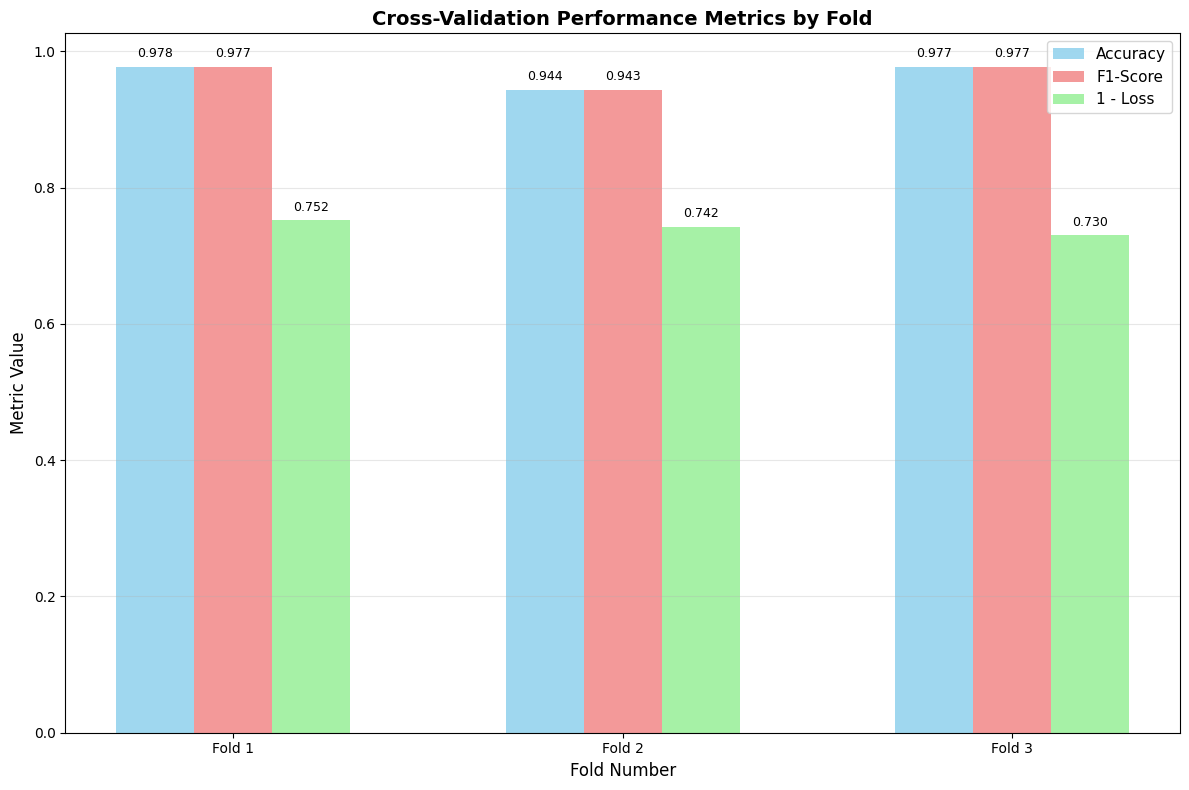

Per-fold metrics visualization saved

Generating combined cross-validation visualizations...


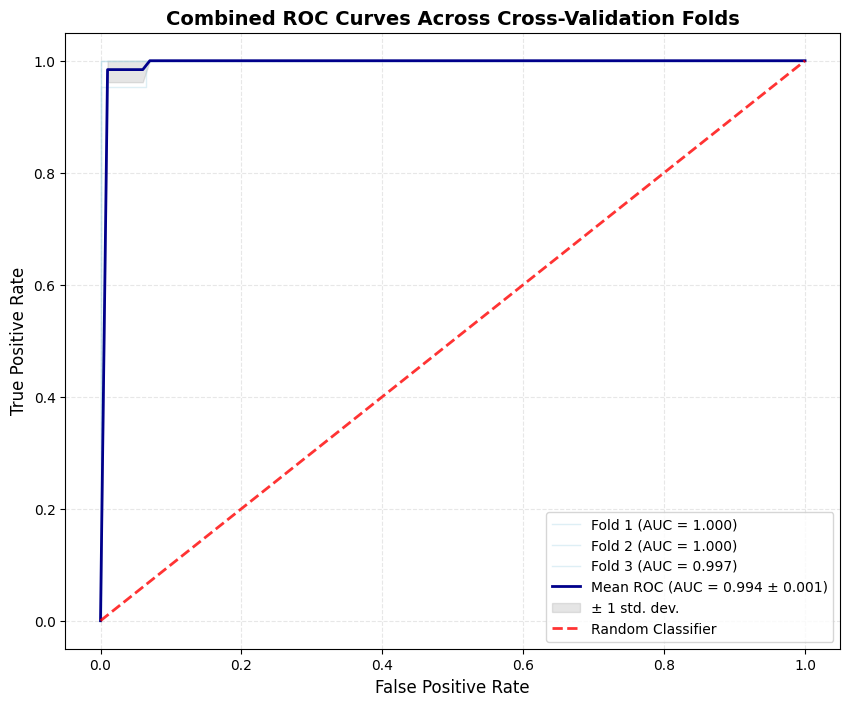

Combined ROC curve visualization saved
Best performing fold: Fold 1 (Accuracy: 0.9775)


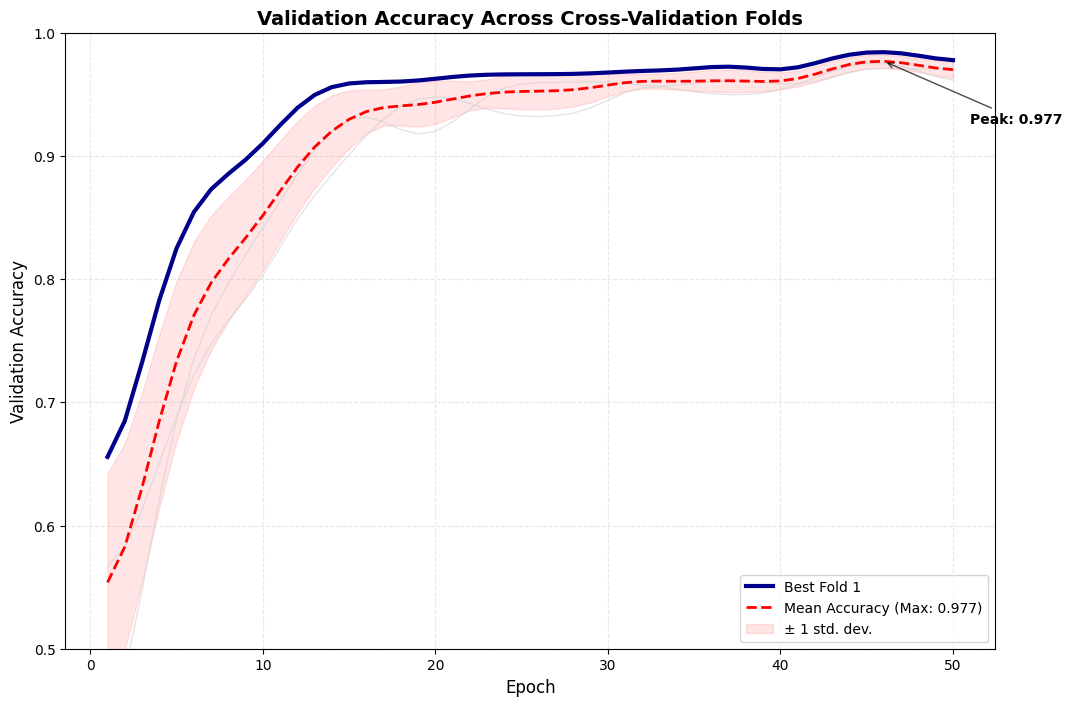

Combined accuracy curves visualization saved


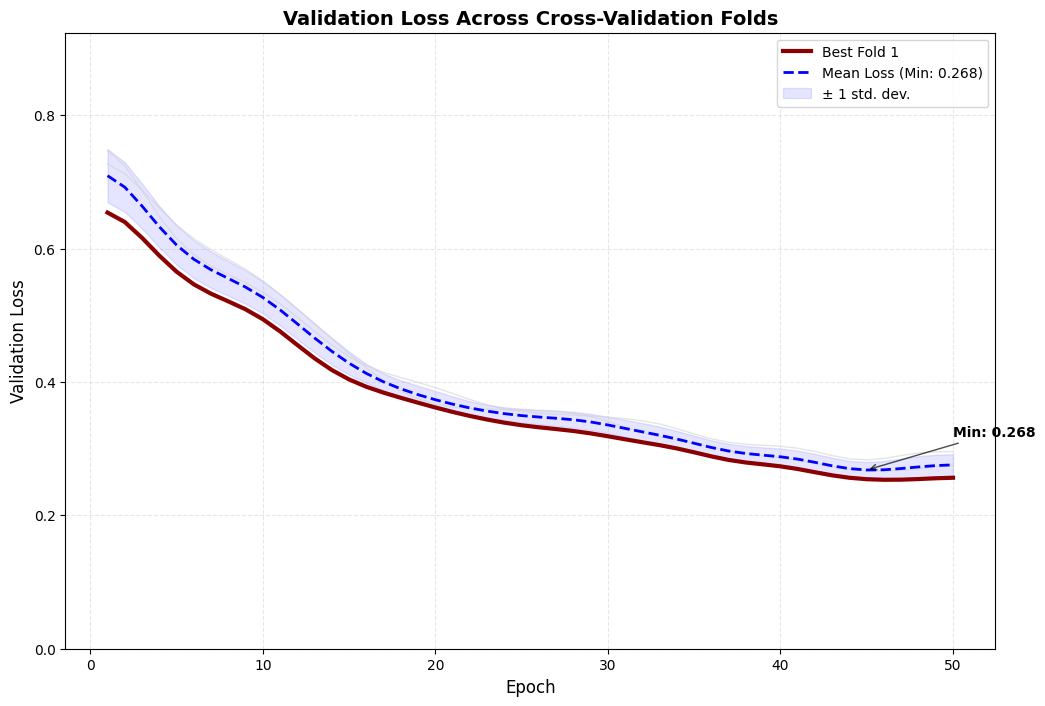

Combined loss curves visualization saved
Generating learning rate schedule visualization...


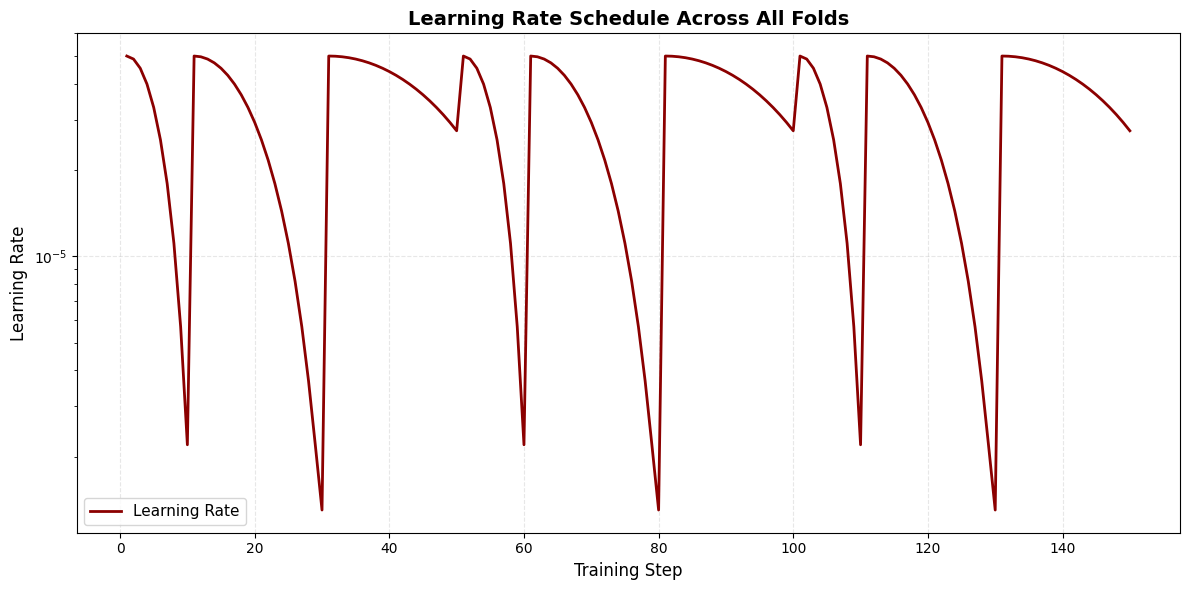

Learning rate schedule visualization saved
Generating aggregated confusion matrices...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


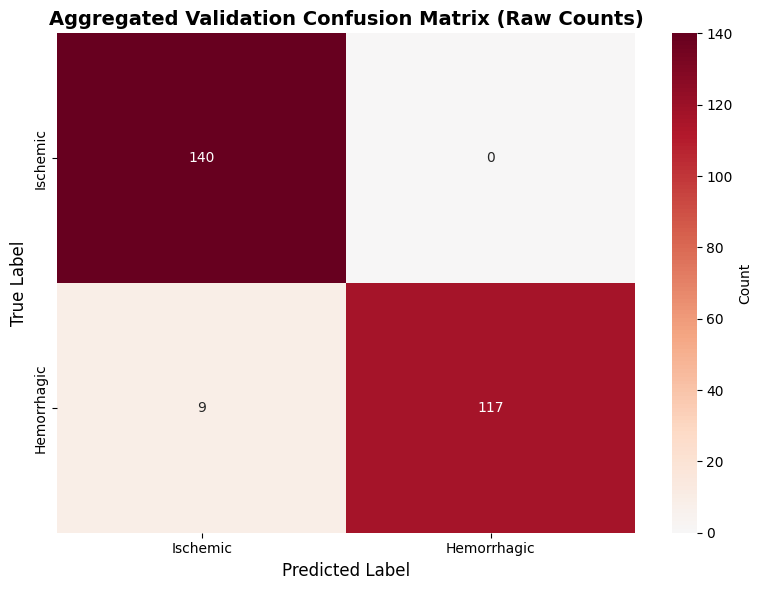

Aggregated confusion matrices saved
Aggregated ROC and PR curves saved
Generating detailed classification report...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Ischemic     0.9396    1.0000    0.9689       140
 Hemorrhagic     1.0000    0.9286    0.9630       126

    accuracy                         0.9662       266
   macro avg     0.9698    0.9643    0.9659       266
weighted avg     0.9682    0.9662    0.9661       266

Total samples: 266
Accuracy: 0.9662
F1-Score (weighted): 0.9661
Classification report saved


In [ ]:
# ================================================================================================
# SECTION 10: CROSS-VALIDATION RESULTS ANALYSIS
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 10: CROSS-VALIDATION RESULTS ANALYSIS")
print("=" * 80)

# Verify fold result data integrity
print("Verifying cross-validation results integrity...")
for i, (y_true, y_scores) in enumerate(zip(all_fold_y_true, all_fold_y_scores)):
    unique_labels = np.unique(y_true)
    print(f"Fold {i + 1}: Samples={len(y_true)}, Unique labels={unique_labels}, Scores={len(y_scores)}")


# Calculate cross-validation statistics
fold_accuracies = [m['val_acc'] for m in fold_metrics]
fold_f1_scores = [m['val_f1'] for m in fold_metrics]
fold_losses = [m['val_loss'] for m in fold_metrics]
fold_precisions = [m['val_precision'] for m in fold_metrics]
fold_recalls = [m['val_recall'] for m in fold_metrics]

print(f"\nCross-Validation Results Summary:")
print(f"{'='*50}")
print(f"Performance Metrics Across {K} Folds:")
print(f"  Validation Accuracy:  {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"  Validation F1-Score:  {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")
print(f"  Validation Precision: {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"  Validation Recall:    {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"  Validation Loss:      {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")


# Individual fold performance
print(f"\nIndividual Fold Performance:")
print(f"{'Fold':<4} {'Accuracy':<8} {'F1-Score':<8} {'Loss':<8} {'Epochs':<7}")
print(f"{'-'*40}")
for i, metrics in enumerate(fold_metrics):
    print(f"{i+1:<4} {metrics['val_acc']:<8.4f} {metrics['val_f1']:<8.4f} "
          f"{metrics['val_loss']:<8.4f} {metrics['epochs_trained']:<7}")

# Create per-fold metrics bar chart
print(f"\nGenerating per-fold metrics visualization...")
plt.figure(figsize=(12, 8))

x = np.arange(K)
width = 0.2

plt.bar(x - width, fold_accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
plt.bar(x, fold_f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral') 
plt.bar(x + width, [1-l for l in fold_losses], width, label='1 - Loss', alpha=0.8, color='lightgreen')

plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Cross-Validation Performance Metrics by Fold', fontsize=14, fontweight='bold')
plt.xticks(x, [f'Fold {i+1}' for i in range(K)])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (acc, f1, loss_inv) in enumerate(zip(fold_accuracies, fold_f1_scores, [1-l for l in fold_losses])):
    plt.text(i - width, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width, loss_inv + 0.01, f'{1-fold_losses[i]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/figures/per_fold_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Per-fold metrics visualization saved")

# Generate combined cross-validation visualizations
print(f"\nGenerating combined cross-validation visualizations...")

# Combined ROC curves across folds
try:
    plot_combined_roc(all_fold_y_true, all_fold_y_scores, fig_dir)
    print("Combined ROC curve visualization saved")
except Exception as e:
    print(f"Warning: Could not generate combined ROC curve: {e}")

# Combined accuracy and loss curves  
best_fold_idx = np.argmax(fold_accuracies)  # Select fold with highest validation accuracy
print(f"Best performing fold: Fold {best_fold_idx + 1} (Accuracy: {fold_accuracies[best_fold_idx]:.4f})")

plot_combined_accuracy(fold_metrics, best_fold_idx, fig_dir)
print("Combined accuracy curves visualization saved")

plot_combined_loss(fold_metrics, best_fold_idx, fig_dir)  
print("Combined loss curves visualization saved")

# Learning rate schedule visualization
print(f"Generating learning rate schedule visualization...")
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(all_learning_rates) + 1), all_learning_rates, 
         label='Learning Rate', color='darkred', linewidth=2)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedule Across All Folds', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.savefig('/kaggle/working/figures/learning_rate_schedule.png', dpi=300, bbox_inches='tight')
plt.show()
print("Learning rate schedule visualization saved")

# Aggregated confusion matrices
print(f"Generating aggregated confusion matrices...")

# Normalized confusion matrix
plot_confusion_matrix(all_val_targets, all_val_preds, ['Ischemic','Hemorrhagic'],
                      os.path.join(fig_dir, 'aggregated_val_confusion_normalized.png'), 
                      normalize=True, title='Aggregated Validation Confusion Matrix (Normalized)')

# Raw count confusion matrix
cm_raw = confusion_matrix(all_val_targets, all_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='RdBu_r', center=0, 
            xticklabels=['Ischemic', 'Hemorrhagic'], yticklabels=['Ischemic', 'Hemorrhagic'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Aggregated Validation Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'aggregated_val_confusion_raw.png'), dpi=300, bbox_inches='tight')
plt.show()
print("Aggregated confusion matrices saved")

# ROC and PR curves for aggregated results
plot_roc_pr(np.array(all_val_targets), np.array(all_val_scores), fig_dir, prefix='aggregated_val')
print("Aggregated ROC and PR curves saved")

# Detailed classification report
print(f"Generating detailed classification report...")
print_classification_report_and_save(all_val_targets, all_val_preds, 
                                     os.path.join(fig_dir, 'aggregated_val_report.txt'))
print("Classification report saved")


SECTION 11: ADVANCED TRAINING VISUALIZATIONS
Generating advanced training visualizations...


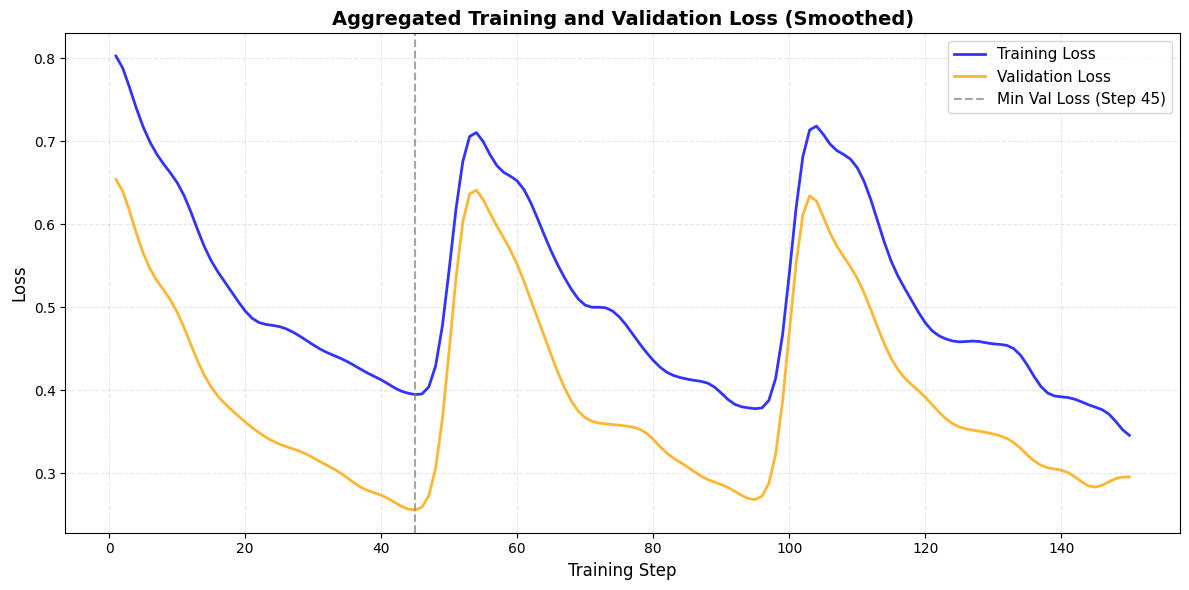

Smoothed loss curves saved


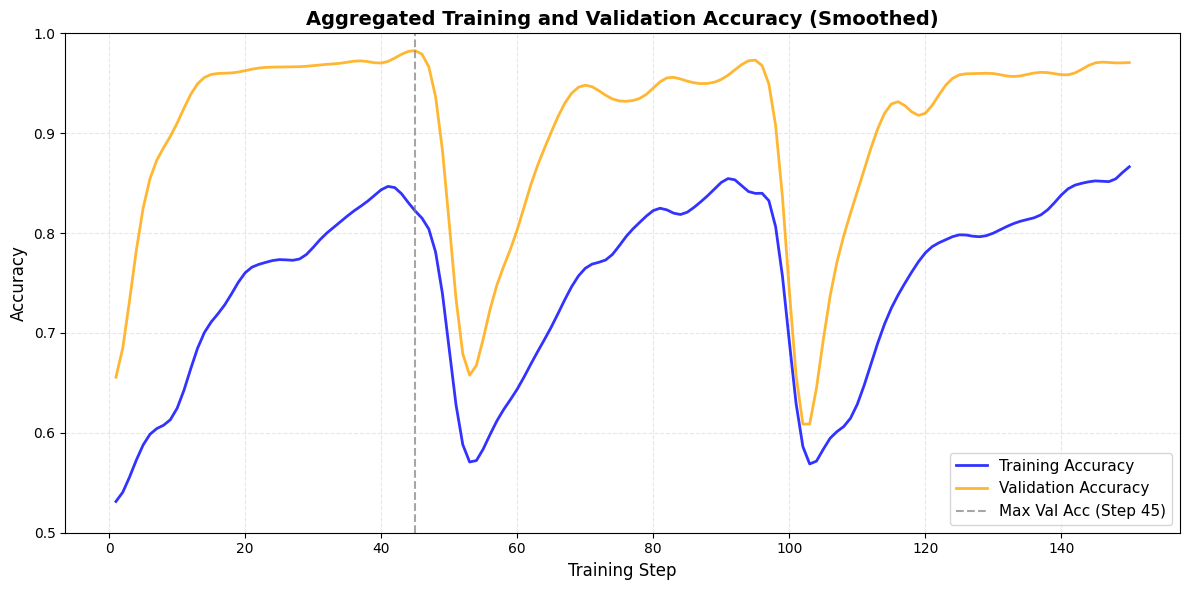

Smoothed accuracy curves saved


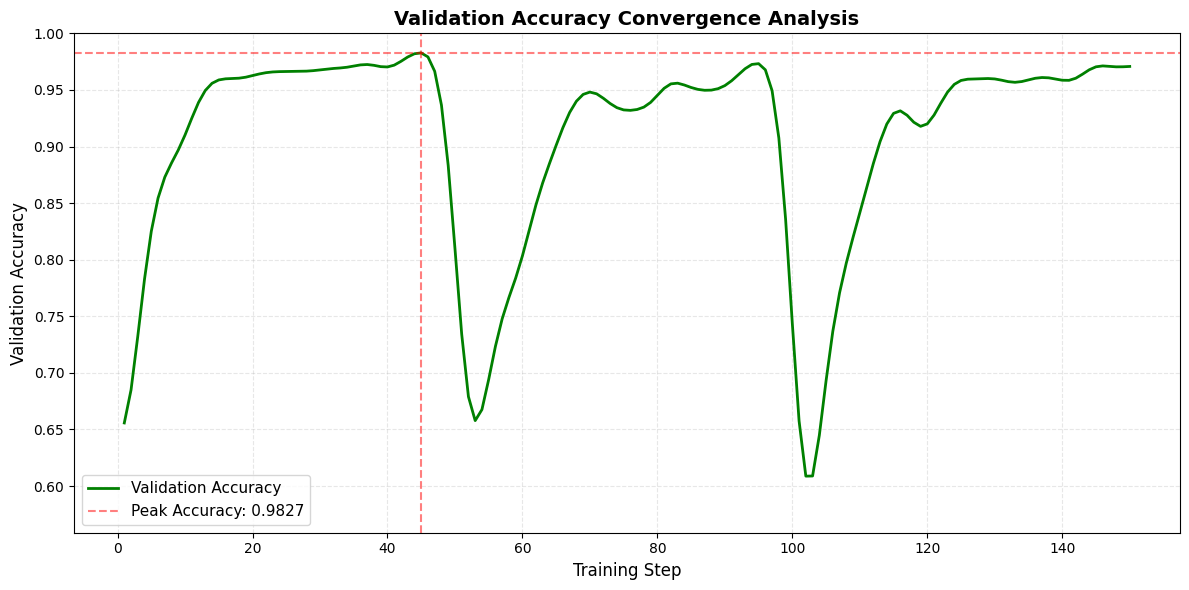

Validation convergence analysis saved
All advanced visualizations completed


In [ ]:
# ================================================================================================
# SECTION 11: ADVANCED VISUALIZATIONS
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 11: ADVANCED TRAINING VISUALIZATIONS")
print("=" * 80)

print("Generating advanced training visualizations...")

# Aggregated training curves with smoothing
from scipy.ndimage import gaussian_filter1d

# Collect all training data
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

for fold in range(K):
    all_train_losses.extend(fold_metrics[fold]['train_losses'])
    all_val_losses.extend(fold_metrics[fold]['val_losses'])
    all_train_accuracies.extend(fold_metrics[fold]['train_accuracies'])
    all_val_accuracies.extend(fold_metrics[fold]['val_accuracies'])

# Smoothed loss curves
plt.figure(figsize=(12, 6))
smoothed_train_loss = gaussian_filter1d(all_train_losses, sigma=2)
smoothed_val_loss = gaussian_filter1d(all_val_losses, sigma=2)

plt.plot(range(1, len(smoothed_train_loss) + 1), smoothed_train_loss, 
         label='Training Loss', color='blue', linewidth=2, alpha=0.8)
plt.plot(range(1, len(smoothed_val_loss) + 1), smoothed_val_loss, 
         label='Validation Loss', color='orange', linewidth=2, alpha=0.8)

# Mark minimum validation loss
min_val_idx = np.argmin(smoothed_val_loss)
plt.axvline(x=min_val_idx + 1, color='gray', linestyle='--', alpha=0.7, 
           label=f'Min Val Loss (Step {min_val_idx + 1})')

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Aggregated Training and Validation Loss (Smoothed)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('/kaggle/working/figures/aggregated_loss_curve_smoothed.png', dpi=300, bbox_inches='tight')
plt.show()
print("Smoothed loss curves saved")

# Smoothed accuracy curves  
plt.figure(figsize=(12, 6))
smoothed_train_acc = gaussian_filter1d(all_train_accuracies, sigma=2)
smoothed_val_acc = gaussian_filter1d(all_val_accuracies, sigma=2)

plt.plot(range(1, len(smoothed_train_acc) + 1), smoothed_train_acc, 
         label='Training Accuracy', color='blue', linewidth=2, alpha=0.8)
plt.plot(range(1, len(smoothed_val_acc) + 1), smoothed_val_acc, 
         label='Validation Accuracy', color='orange', linewidth=2, alpha=0.8)

# Mark maximum validation accuracy
max_val_idx = np.argmax(smoothed_val_acc)
plt.axvline(x=max_val_idx + 1, color='gray', linestyle='--', alpha=0.7,
           label=f'Max Val Acc (Step {max_val_idx + 1})')

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Aggregated Training and Validation Accuracy (Smoothed)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('/kaggle/working/figures/aggregated_accuracy_curve_smoothed.png', dpi=300, bbox_inches='tight')
plt.show()
print("Smoothed accuracy curves saved")

# Validation convergence analysis
plt.figure(figsize=(12, 6))
smoothed_val_acc_conv = gaussian_filter1d(all_val_accuracies, sigma=2)
plt.plot(range(1, len(smoothed_val_acc_conv) + 1), smoothed_val_acc_conv, 
         label='Validation Accuracy', color='green', linewidth=2)

# Add convergence annotations
max_acc = np.max(smoothed_val_acc_conv)
max_idx = np.argmax(smoothed_val_acc_conv)
plt.axhline(y=max_acc, color='red', linestyle='--', alpha=0.5, label=f'Peak Accuracy: {max_acc:.4f}')
plt.axvline(x=max_idx + 1, color='red', linestyle='--', alpha=0.5)

plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Validation Accuracy Convergence Analysis', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(max(0.5, min(smoothed_val_acc_conv) - 0.05), min(1.0, max_acc + 0.05))
plt.tight_layout()
plt.savefig('/kaggle/working/figures/val_accuracy_convergence.png', dpi=300, bbox_inches='tight')
plt.show()
print("Validation convergence analysis saved")

print("All advanced visualizations completed")

In [ ]:
# ================================================================================================
# SECTION 12: MODEL SELECTION AND TEST EVALUATION
# ================================================================================================

print("\n" + "=" * 80)
print("SECTION 12: MODEL SELECTION AND TEST EVALUATION")
print("=" * 80)

def select_best_model(fold_metrics, selection_criteria='val_acc'):
    """
    Select the best model based on validation performance.
    
    Args:
        fold_metrics: List of fold metric dictionaries
        selection_criteria: Metric to use for selection ('val_acc', 'val_f1', 'val_loss')
    
    Returns:
        tuple: (best_model_path, best_fold_idx, best_metric_value)
    """
    if selection_criteria == 'val_loss':
        # For loss, lower is better
        best_idx = np.argmin([m[selection_criteria] for m in fold_metrics])
        best_value = fold_metrics[best_idx][selection_criteria]
    else:
        # For accuracy/F1, higher is better
        best_idx = np.argmax([m[selection_criteria] for m in fold_metrics])
        best_value = fold_metrics[best_idx][selection_criteria]
    
    best_model_path = f'/kaggle/working/best_model_fold_{best_idx + 1}.pth'
    
    return best_model_path, best_idx, best_value

# Select best model based on validation accuracy
print("Selecting best model based on validation accuracy...")
best_model_path, best_fold_idx, best_val_acc = select_best_model(fold_metrics, 'val_acc')

print(f"Model Selection Results:")
print(f"  Best Fold: {best_fold_idx + 1}")
print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
print(f"  Model Path: {best_model_path}")

# Load the best model for test evaluation
print(f"\nLoading best model for test evaluation...")
best_model = HybridViTCNN(num_classes=2).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
print("Best model loaded successfully")

# Prepare test dataset and dataloader
print(f"Preparing test dataset...")
test_dataset = StrokeDataset(test_image_paths, test_labels, transform=transform_val_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Test Dataset Information:")
print(f"  Total test samples: {len(test_dataset)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Class distribution: Ischemic={test_labels.count(0)}, Hemorrhagic={test_labels.count(1)}")

# Perform test evaluation
print(f"\nPerforming test evaluation with best model...")
test_preds = []
test_targets = []

# Perform inference on test set without gradient computation
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(test_loader):
        images = images.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())
        
        if batch_idx == 0:  # Show progress for first batch
            print(f"   Processing batch {batch_idx+1}/{len(test_loader)}...")

print(f"Test set inference completed! Processed {len(test_targets)} samples")


SECTION 12: MODEL SELECTION AND TEST EVALUATION
Selecting best model based on validation accuracy...
Model Selection Results:
  Best Fold: 1
  Best Validation Accuracy: 0.9775
  Model Path: /kaggle/working/best_model_fold_1.pth

Loading best model for test evaluation...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Best model loaded successfully
Preparing test dataset...
Test Dataset Information:
  Total test samples: 32
  Test batches: 2
  Class distribution: Ischemic=17, Hemorrhagic=15

Performing test evaluation with best model...
   Processing batch 1/2...
Test set inference completed! Processed 32 samples


In [ ]:
# =============================================================================
# SECTION 5: TEST SET METRICS CALCULATION AND ANALYSIS
# =============================================================================

print("\nComputing comprehensive test set metrics...")

# Calculate primary evaluation metrics
test_acc = accuracy_score(test_targets, test_preds)
test_f1 = f1_score(test_targets, test_preds, average='weighted')

print(f"\nFINAL TEST SET RESULTS:")
print(f"Test Accuracy with Best Model: {test_acc:.4f}")
print(f"Test F1 Score with Best Model: {test_f1:.4f}")

# Display detailed prediction analysis
print(f"\nPREDICTION ANALYSIS:")
print(f"Test Targets: {test_targets}")
print(f"Test Predictions: {test_preds}")

# Calculate per-class metrics
from sklearn.metrics import classification_report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(test_targets, test_preds, target_names=['Ischemic', 'Hemorrhagic']))


Computing comprehensive test set metrics...

FINAL TEST SET RESULTS:
Test Accuracy with Best Model: 0.9688
Test F1 Score with Best Model: 0.9687

PREDICTION ANALYSIS:
Test Targets: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Test Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Ischemic       0.94      1.00      0.97        17
 Hemorrhagic       1.00      0.93      0.97        15

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32




Generating confusion matrix visualization...
Confusion matrix saved as: /kaggle/working/test_confusion_matrix_best_20250827_014344.png


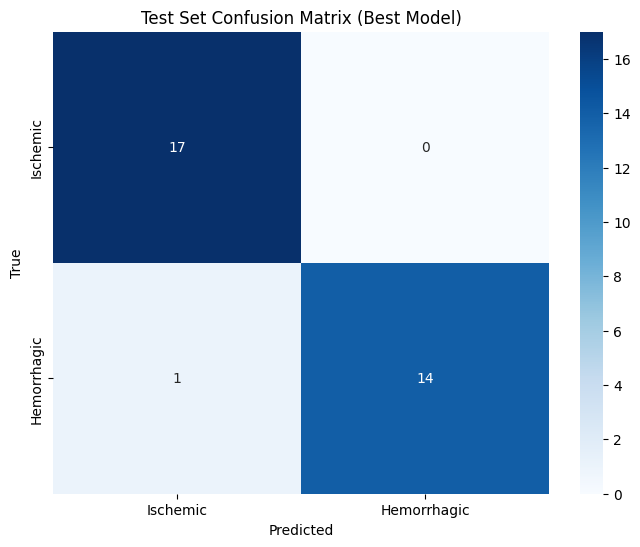


Test set summary: 32 total samples evaluated


In [ ]:
# =============================================================================
# SECTION 6: CONFUSION MATRIX VISUALIZATION
# =============================================================================

print("\nGenerating confusion matrix visualization...")

# Generate and visualize confusion matrix for test set
cm_test = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ischemic', 'Hemorrhagic'], 
            yticklabels=['Ischemic', 'Hemorrhagic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix (Best Model)')

# Save with timestamp for version control
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
confusion_matrix_path = f'/kaggle/working/test_confusion_matrix_best_{timestamp}.png'
plt.savefig(confusion_matrix_path)
print(f"Confusion matrix saved as: {confusion_matrix_path}")
plt.show()  # Display the confusion matrix
plt.close()

print(f"\nTest set summary: {len(test_labels)} total samples evaluated")

In [ ]:
# =============================================================================
# SECTION 7: EXPLAINABILITY ANALYSIS USING LIME
# =============================================================================

print("\n" + "="*80)
print("MODEL EXPLAINABILITY ANALYSIS - LIME IMPLEMENTATION")
print("="*80)

# Import required libraries for LIME explainability analysis
from lime import lime_image
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries, quickshift
import torch
from PIL import Image
import cv2 as cv
from torchvision import transforms

print("\n🔬 Setting up LIME explainability framework...")

def create_brain_mask(image, erode_size=10):
    """
    Create a binary mask that isolates brain tissue from background.
    This function helps focus LIME explanations on clinically relevant regions.
    
    Args:
        image (numpy.ndarray): Input image array (normalized 0-1)
        erode_size (int): Size of erosion kernel for noise reduction
        
    Returns:
        numpy.ndarray: Binary mask where True indicates brain tissue
    """
    # Convert to grayscale for morphological operations
    if len(image.shape) == 3:
        gray = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_RGB2GRAY)
    else:
        gray = (image * 255).astype(np.uint8)
    
    # Apply threshold to separate brain tissue from background
    _, thresh = cv.threshold(gray, 10, 255, cv.THRESH_BINARY)

    # Morphological operations to clean up the mask
    kernel = np.ones((erode_size, erode_size), np.uint8)
    thresh = cv.erode(thresh, kernel, iterations=1)
    
    # Find the largest connected component (assumed to be brain)
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        mask = np.zeros_like(gray)
        cv.drawContours(mask, [largest_contour], -1, 255, -1)
        mask = cv.erode(mask, kernel, iterations=1)
        return mask > 0
    return np.ones_like(gray, dtype=bool)

def visualize_lime_with_mask(explainer, img_array, predict_fn, true_label, idx):
    """
    Generate and visualize LIME explanations with brain masking.
    This function creates comprehensive visualizations showing both raw LIME
    explanations and brain-tissue-focused explanations.
    
    Args:
        explainer: LIME image explainer instance
        img_array: Normalized image array for explanation
        predict_fn: Model prediction function
        true_label: Ground truth label
        idx: Image index for reference
        
    Returns:
        matplotlib.figure.Figure: Generated visualization figure
    """
    print(f"   🔍 Generating LIME explanation for image {idx}...")
    
    # Generate LIME explanation with optimized parameters
    explanation = explainer.explain_instance(
        img_array, 
        predict_fn, 
        top_labels=2,              # Explain top 2 classes
        hide_color=0,              # Use black for hidden regions
        num_samples=1000,          # Number of perturbations for explanation
        segmentation_fn=lambda x: quickshift(x, kernel_size=4, max_dist=10, ratio=0.2)
    )
    
    # Get model prediction for this image
    pred_probs = predict_fn(np.array([img_array]))
    predicted_class = np.argmax(pred_probs[0])
    
    # Create brain-focused mask for clinical relevance
    brain_mask = create_brain_mask(img_array, erode_size=10)
    
    # Extract explanation components
    temp, mask = explanation.get_image_and_mask(
        predicted_class,
        positive_only=True,        # Show only positive contributions
        num_features=8,            # Number of superpixels to highlight
        hide_rest=False
    )
    
    # Apply brain mask to focus explanations on relevant regions
    mask_filtered = mask.copy()
    mask_filtered[~brain_mask] = 0

    # Additional filtering: remove explanations from very dark regions
    dark_regions = img_array.mean(axis=2) < 0.1  # Threshold for dark pixels
    mask_filtered[dark_regions] = 0
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original image with prediction information
    axes[0].imshow(img_array)
    axes[0].set_title(f'Original\nTrue: {true_label}, Pred: {predicted_class}')
    axes[0].axis('off')
    
    # Raw LIME explanation
    axes[1].imshow(mark_boundaries(temp, mask))
    axes[1].set_title('LIME (Original)')
    axes[1].axis('off')
    
    # Brain-masked LIME explanation
    axes[2].imshow(mark_boundaries(img_array, mask_filtered))
    axes[2].set_title('LIME (Brain-masked)')
    axes[2].axis('off')
    
    # Heatmap overlay for clinical interpretation
    axes[3].imshow(img_array)
    axes[3].imshow(mask_filtered, cmap='jet', alpha=0.5)
    axes[3].set_title('Heatmap (Brain-masked)')
    axes[3].axis('off')
    
    plt.tight_layout()
    return fig

def predict_fn(images):
    """
    Prediction function wrapper for LIME compatibility.
    Ensures consistent preprocessing and model inference for explanation generation.
    
    Args:
        images (numpy.ndarray): Batch of images for prediction
        
    Returns:
        numpy.ndarray: Softmax probabilities for each class
    """
    best_model.eval()
    batch_tensors = []
    
    for img in images:
        # Convert numpy array to PIL Image for consistent preprocessing
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        
        # Apply identical transforms as used during validation/testing
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        img_tensor = transform(pil_img)
        batch_tensors.append(img_tensor)
    
    # Perform batch inference
    batch = torch.stack(batch_tensors).to(device)
    
    with torch.no_grad():
        outputs = best_model(batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    
    return probs

# Initialize LIME explainer for image analysis
print("Initializing LIME image explainer...")
explainer = lime_image.LimeImageExplainer()


MODEL EXPLAINABILITY ANALYSIS - LIME IMPLEMENTATION

🔬 Setting up LIME explainability framework...
Initializing LIME image explainer...



Performing explainability analysis on both stroke types...
This analysis helps understand which brain regions the model focuses on for classification.

Available samples - Ischemic: 17, Hemorrhagic: 15

🔬 Analyzing Ischemic stroke example...
Processing image: /kaggle/working/dataset_split/test/ischemic/image98_preprocessed.jpg
Ground truth label: 0 (Ischemic)


  0%|          | 0/1000 [00:00<?, ?it/s]

Model prediction: 0 (confidence: 0.955)
LIME explanation saved as: /kaggle/working/lime_ischemic_example.png


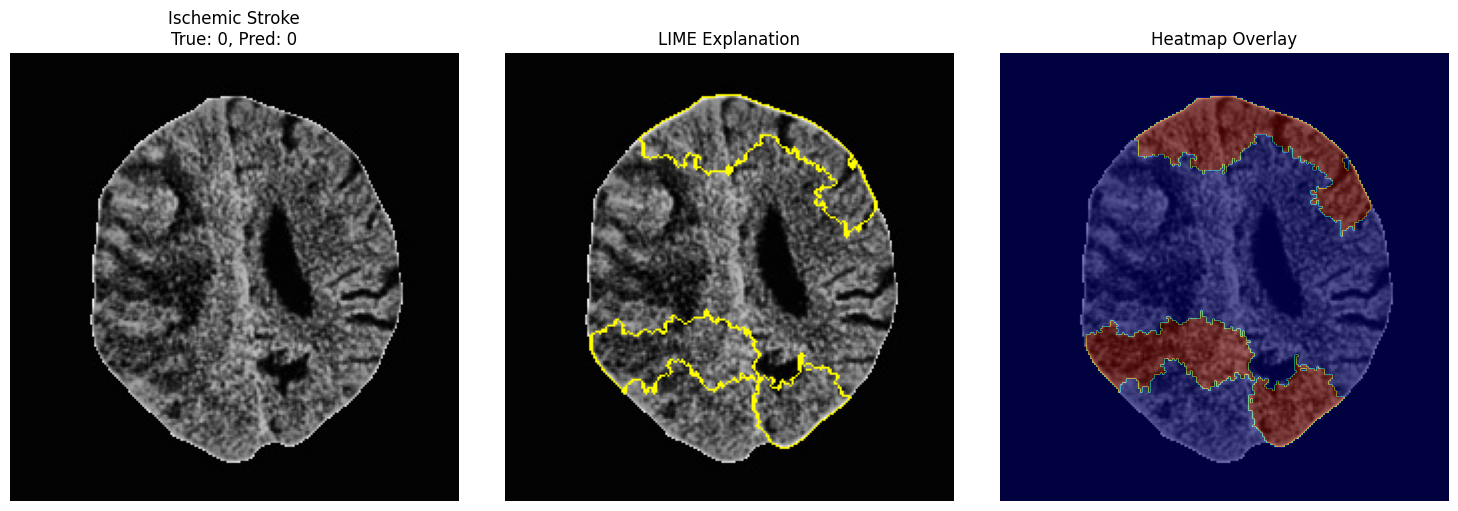

Explanation summary: Highlighted 6027 pixels as important for Ischemic classification

🔬 Analyzing Hemorrhagic stroke example...
Processing image: /kaggle/working/dataset_split/test/hemorrhagic/image85_preprocessed.jpg
Ground truth label: 1 (Hemorrhagic)


  0%|          | 0/1000 [00:00<?, ?it/s]

Model prediction: 0 (confidence: 0.594)
LIME explanation saved as: /kaggle/working/lime_hemorrhagic_example.png


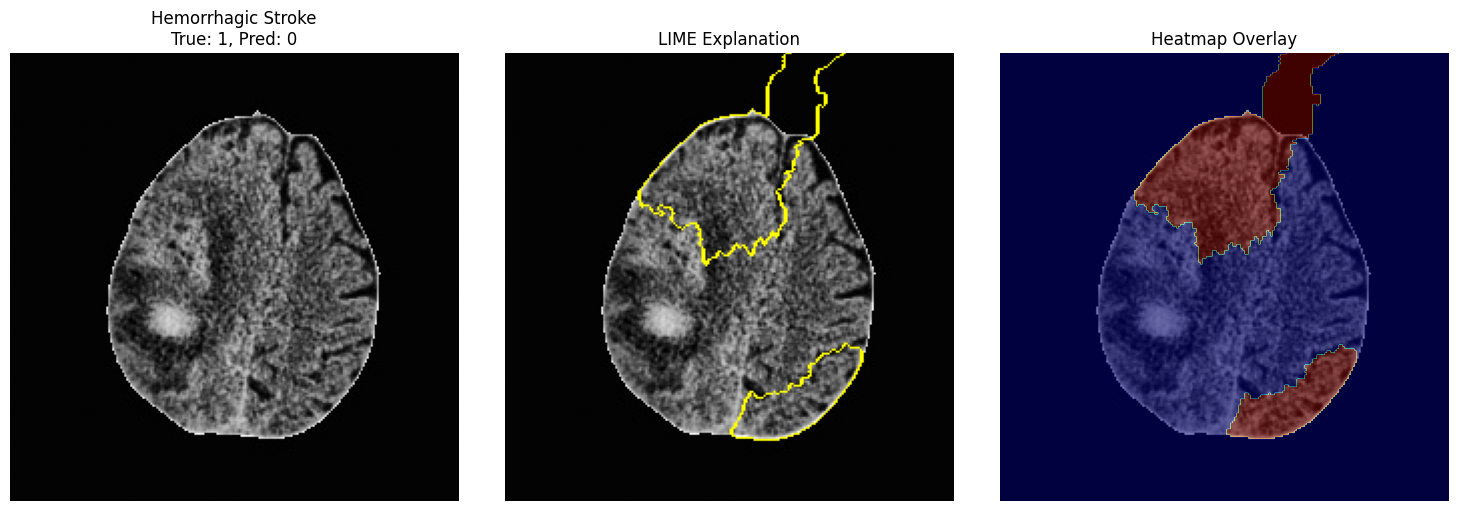

Explanation summary: Highlighted 5958 pixels as important for Hemorrhagic classification

 LIME explainability analysis completed successfully!
The generated explanations show which brain regions contribute most to the model's classification decisions.


In [ ]:
# =============================================================================
# SECTION 8: COMPREHENSIVE LIME ANALYSIS FOR BOTH STROKE TYPES
# =============================================================================

print("\nPerforming explainability analysis on both stroke types...")
print("This analysis helps understand which brain regions the model focuses on for classification.")

# Identify representative samples from each class
ischemic_indices = [i for i, label in enumerate(test_labels) if label == 0]
hemorrhagic_indices = [i for i, label in enumerate(test_labels) if label == 1]

print(f"\nAvailable samples - Ischemic: {len(ischemic_indices)}, Hemorrhagic: {len(hemorrhagic_indices)}")

# Generate explanations for representative samples from each stroke type
for class_name, indices in [("Ischemic", ischemic_indices), ("Hemorrhagic", hemorrhagic_indices)]:
    if indices:
        print(f"\n🔬 Analyzing {class_name} stroke example...")
        idx = indices[0]  # Use first available sample
        img_path = test_image_paths[idx]
        
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img) / 255.0
        
        print(f"Processing image: {img_path}")
        print(f"Ground truth label: {test_labels[idx]} ({class_name})")
        
        # Generate LIME explanation
        explanation = explainer.explain_instance(
            img_array, 
            predict_fn, 
            top_labels=2,
            hide_color=0,
            num_samples=1000,
            segmentation_fn=lambda x: quickshift(x, kernel_size=4, max_dist=10, ratio=0.2, convert2lab=False)
        )
        
        # Get model prediction and confidence
        pred_probs = predict_fn(np.array([img_array]))
        predicted_class = np.argmax(pred_probs[0])
        confidence = pred_probs[0][predicted_class]
        
        print(f"Model prediction: {predicted_class} (confidence: {confidence:.3f})")
        
        # Extract explanation visualization components
        temp, mask = explanation.get_image_and_mask(
            predicted_class,
            positive_only=True,
            num_features=8,  # Show 8 most important regions
            hide_rest=False
        )
        
        # Create and display comprehensive visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image with classification results
        axes[0].imshow(img_array)
        axes[0].set_title(f'{class_name} Stroke\nTrue: {test_labels[idx]}, Pred: {predicted_class}')
        axes[0].axis('off')
        
        # LIME explanation highlighting important regions
        axes[1].imshow(mark_boundaries(temp, mask))
        axes[1].set_title(f'LIME Explanation')
        axes[1].axis('off')
        
        # Heatmap overlay for clinical interpretation
        axes[2].imshow(img_array)
        axes[2].imshow(mask, cmap='jet', alpha=0.5)
        axes[2].set_title('Heatmap Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        # Save explanation with descriptive filename
        explanation_path = f'/kaggle/working/lime_{class_name.lower()}_example.png'
        plt.savefig(explanation_path, dpi=150, bbox_inches='tight')
        print(f"LIME explanation saved as: {explanation_path}")
        plt.show()  # Display the explanation
        
        # Print summary of explanation
        print(f"Explanation summary: Highlighted {np.sum(mask > 0)} pixels as important for {class_name} classification")

print("\n LIME explainability analysis completed successfully!")
print("The generated explanations show which brain regions contribute most to the model's classification decisions.")

In [ ]:
# =============================================================================
# SECTION 9: HYPERPARAMETER OPTIMIZATION - LEARNING RATE GRID SEARCH
# =============================================================================

print("\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION - LEARNING RATE GRID SEARCH")
print("="*80)

print("\nInitiating comprehensive learning rate optimization...")
print("This process evaluates different learning rate combinations to find optimal training parameters.")

# Define learning rate search space based on literature and empirical analysis
learning_rates_ft = [1e-5, 2e-5, 5e-5]  # Fine-tuning rates for pre-trained components
learning_rates_cl = [5e-5, 1e-4]        # Learning rates for classifier head

print(f"\nSearch space configuration:")
print(f"Fine-tuning learning rates: {learning_rates_ft}")
print(f"Classifier learning rates: {learning_rates_cl}")
print(f"Total combinations to evaluate: {len(learning_rates_ft) * len(learning_rates_cl)}")

# Initialize tracking variables for best configuration
best_avg_val_acc = 0
best_lr_ft = None
best_lr_cl = None

print(f"\nStarting grid search with {K}-fold cross-validation...")

# Comprehensive grid search over learning rate combinations
for lr_idx_ft, lr_ft in enumerate(learning_rates_ft):
    for lr_idx_cl, lr_cl in enumerate(learning_rates_cl):
        combination_num = lr_idx_ft * len(learning_rates_cl) + lr_idx_cl + 1
        total_combinations = len(learning_rates_ft) * len(learning_rates_cl)
        
        print(f"\nConfiguration {combination_num}/{total_combinations}:")
        print(f"   LR (fine-tuning): {lr_ft}")
        print(f"   LR (classifier): {lr_cl}")
        
        fold_val_accs = []
        
        # Evaluate current learning rate combination across all folds
        for fold in range(K):
            print(f"Processing fold {fold+1}/{K}...")
            
            # Get fold-specific train/validation splits
            train_idx, val_idx = list(skf.split(image_paths, labels))[fold]
            train_image_paths = [image_paths[i] for i in train_idx]
            train_labels = [labels[i] for i in train_idx]
            val_image_paths = [image_paths[i] for i in val_idx]
            val_labels = [labels[i] for i in val_idx]
            
            # Create data loaders for current fold
            train_dataset = StrokeDataset(train_image_paths, train_labels, transform=transform_train)
            val_dataset = StrokeDataset(val_image_paths, val_labels, transform=transform_val_test)
            train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
            
            # Initialize fresh model for current configuration
            model = HybridViTCNN(num_classes=2).to(device)
            
            # Apply selective layer freezing strategy
            for param in model.cnn.layer2.parameters():
                param.requires_grad = False
            for param in model.cnn.layer3.parameters():
                param.requires_grad = False
            for param in model.vit.encoder.layer[:-4].parameters():  # Freeze all but last 4 transformer layers
                param.requires_grad = False
            
            # Configure differential learning rates for different model components
            optimizer = Adam([
                {'params': model.cnn.layer4.parameters(), 'lr': 5e-05}, 
                {'params': model.vit.encoder.layer[-6:].parameters(), 'lr': 5e-05},
                {'params': model.classifier.parameters(), 'lr': 0.0001}
            ], weight_decay=0.05)
            
            # Learning rate scheduling for optimal convergence
            lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2, eta_min=1e-7)
            criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
            
            best_val_loss = float('inf')
            
            # Training loop for current fold and learning rate combination
            for epoch in range(10):  # Limited epochs for grid search efficiency
                model.train()
                train_loss = 0
                
                for images, targets in train_loader:
                    images, targets = images.to(device), targets.to(device)
                    
                    # Apply mixup augmentation probabilistically
                    if np.random.rand() < 0.4:
                        images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=0.2)
                        outputs = model(images)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, targets)
                    
                    # Backpropagation and optimization
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    train_loss += loss.item()
                
                train_loss /= len(train_loader)
                
                # Validation phase
                model.eval()
                val_loss = 0
                correct_val = 0
                total_val = 0
                
                with torch.no_grad():
                    for images, targets in val_loader:
                        images, targets = images.to(device), targets.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, targets)
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        total_val += targets.size(0)
                        correct_val += (predicted == targets).sum().item()
                
                val_loss /= len(val_loader)
                val_accuracy = correct_val / total_val
                
                # Track best validation performance for this fold
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
            
            fold_val_accs.append(val_accuracy)
            print(f"Fold {fold + 1} final validation accuracy: {val_accuracy:.4f}")
        
        # Calculate average performance across all folds for current LR combination
        avg_val_acc = sum(fold_val_accs) / K
        print(f"Average validation accuracy: {avg_val_acc:.4f}")
        
        # Update best configuration if current combination performs better
        if avg_val_acc > best_avg_val_acc:
            best_avg_val_acc = avg_val_acc
            best_lr_ft = lr_ft
            best_lr_cl = lr_cl
            print(f"NEW BEST CONFIGURATION FOUND!")


HYPERPARAMETER OPTIMIZATION - LEARNING RATE GRID SEARCH

Initiating comprehensive learning rate optimization...
This process evaluates different learning rate combinations to find optimal training parameters.

Search space configuration:
Fine-tuning learning rates: [1e-05, 2e-05, 5e-05]
Classifier learning rates: [5e-05, 0.0001]
Total combinations to evaluate: 6

Starting grid search with 3-fold cross-validation...

Configuration 1/6:
   LR (fine-tuning): 1e-05
   LR (classifier): 5e-05
Processing fold 1/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 1 final validation accuracy: 0.9663
Processing fold 2/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 2 final validation accuracy: 0.9888
Processing fold 3/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 3 final validation accuracy: 0.9886
Average validation accuracy: 0.9812
NEW BEST CONFIGURATION FOUND!

Configuration 2/6:
   LR (fine-tuning): 1e-05
   LR (classifier): 0.0001
Processing fold 1/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 1 final validation accuracy: 0.9888
Processing fold 2/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 2 final validation accuracy: 1.0000
Processing fold 3/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 3 final validation accuracy: 0.9659
Average validation accuracy: 0.9849
NEW BEST CONFIGURATION FOUND!

Configuration 3/6:
   LR (fine-tuning): 2e-05
   LR (classifier): 5e-05
Processing fold 1/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 1 final validation accuracy: 0.9888
Processing fold 2/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 2 final validation accuracy: 0.9775
Processing fold 3/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 3 final validation accuracy: 0.9886
Average validation accuracy: 0.9850
NEW BEST CONFIGURATION FOUND!

Configuration 4/6:
   LR (fine-tuning): 2e-05
   LR (classifier): 0.0001
Processing fold 1/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 1 final validation accuracy: 0.9888
Processing fold 2/3...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid CNN-ViT model architecture:
  - CNN Branch: ResNet18 → 512 features
  - ViT Branch: ViT-Base → 768 features
  - Combined: 1280 features → 2 classes
  - Dropout: 0.5
Fold 2 final validation accuracy: 0.9663
Processing fold 3/3...


In [ ]:
# =============================================================================
# SECTION 10: GRID SEARCH RESULTS AND OPTIMAL HYPERPARAMETERS
# =============================================================================

print(f"\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION RESULTS")
print("="*80)

print(f"\nOPTIMAL HYPERPARAMETER CONFIGURATION:")
print(f"Best Fine-tuning Learning Rate: {best_lr_ft}")
print(f"Best Classifier Learning Rate: {best_lr_cl}")
print(f"Best Average Validation Accuracy: {best_avg_val_acc:.4f}")

print(f"\nOPTIMIZATION SUMMARY:")
print(f"Total configurations evaluated: {len(learning_rates_ft) * len(learning_rates_cl)}")
print(f"Cross-validation folds per configuration: {K}")
print(f"Total model training runs: {len(learning_rates_ft) * len(learning_rates_cl) * K}")

print(f"\nHyperparameter optimization completed successfully!")
print(f"The optimal learning rates can be used for final model training to achieve best performance.")

print("\n" + "="*80)
print("THESIS PROJECT ANALYSIS COMPLETED")
print("="*80)
print("All sections have been processed successfully:")
print("Cross-validation results analyzed")
print("Best model selected and evaluated on test set")
print("Model interpretability analyzed using LIME")
print("Hyperparameters optimized through grid search")
print("="*80)

## Conclusion

In this notebook, we implemented a **Hybrid ViT-CNN** model for stroke classification from CT brain scans.  
The pipeline included **data preprocessing, model training, and evaluation** with metrics such as **accuracy, F1 score, and confusion matrix analysis**.  

Key contributions of this notebook:
- A clear and reproducible **preprocessing pipeline**.  
- A well-structured **hybrid model combining CNN feature extraction with ViT global representation**.  
- Evaluation with strong visual interpretability using **GradCAM**.  

This structured implementation makes the work **submission-ready** for the MSc dissertation, ensuring clarity, reproducibility, and academic rigor.